In [ ]:
!git clone https://github.com/mauriciocruzriveros/BasededatosFlavonoides

In [ ]:
cd BasededatosFlavonoides/

In [ ]:
!pip install rdkit

In [ ]:
!pip install pingouin

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import rdkit
import re

# <span style="color:magenta">Dataframe</span> Flavonoides
_________________________________________________________________________________________________________________________________________________________

In [3]:
df = pd.read_csv("flavonoids_data_final.csv")
df.head()

,ChEBI ID,ChEBI Name,SMILES,PubChem SID,deltag
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,SID: 85377015\nCID: 131835070,-9.4
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,SID: 85390422\nCID: 131752849,-9.9
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,SID: 85385648\nCID: 44260005,-10.3
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,SID: 85395895\nCID: 13916054,-10.6
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,SID: 85387578\nCID: 11016019,-9.0


## <u>Preparación del <span style="color:magenta">Df</span></u>

* #### Separamos la columa PubChem SID

In [6]:
def extraer_sid_cid(row):
    if pd.isna(row):
        return None, None
    sid_match = re.search(r'SID:\s*(\d+)', str(row))
    cid_match = re.search(r'CID:\s*(\d+)', str(row))
    sid = sid_match.group(1) if sid_match else None
    cid = cid_match.group(1) if cid_match else None
    return sid, cid

# Aplicar la funcion al Df 
df['SID'], df['CID'] = zip(*df['PubChem SID'].apply(extraer_sid_cid))
df[["PubChem SID",'SID', 'CID']].sample(n=4)

,PubChem SID,SID,CID
191,CID: 10452846\nSID: 85375002,85375002,10452846
593,CID: 5856141\nSID: 85374985,85374985,5856141
866,CID: 131836490\nSID: 85392110,85392110,131836490
434,SID: 85391954\nCID: 131833502,85391954,131833502


In [7]:
df = df.drop("PubChem SID", axis=1)
df.head()

,ChEBI ID,ChEBI Name,SMILES,deltag,SID,CID
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,-9.4,85377015,131835070
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,-9.9,85390422,131752849
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,-10.3,85385648,44260005
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,-10.6,85395895,13916054
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,-9.0,85387578,11016019


* #### Verificar si RDkit reconoce nuestros SMILES correctamente

In [9]:
smiles_column = df["SMILES"]
num_molecules_recognized = 0
# Verificar cada SMILES con RdKit
for smiles in smiles_column:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        num_molecules_recognized += 1
    else:
        print(f"SMILES: {smiles} - No se pudo reconocer")
print(f"Total de moléculas reconocidas correctamente: {num_molecules_recognized}")

Total de moléculas reconocidas correctamente: 1531


<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">

### <i class="fas fa-trash-alt"></i> Eliminar nulos de columna delta_g

In [11]:
mask = df['deltag'].isnull()  # Mascara valores nulos deltag
filas_con_nulos = df[mask]    # Aplicar mascara a Df

#Mostrar 
columnas_a_mostrar = ['ChEBI ID', 'ChEBI Name', 'deltag'] 
print(df[mask][columnas_a_mostrar])                                             # Mostrar filas afectadas
cantidad_filas_con_nulos = len(df[mask])
print(f"La cantidad de moléculas sin 'deltag' es: {cantidad_filas_con_nulos}")  # Contar moleculas sin valor delta_g
df = df.dropna(subset=['deltag'])                                               # Contar filas eliminadas
print(f"Se eliminaron : {cantidad_filas_con_nulos} moleculas")

      ChEBI ID                                         ChEBI Name  deltag
179     189019                             Cyanidin 3-arabinoside     NaN
198     176111                             Peonidin 3-arabinoside     NaN
347      72576                                            aurones     NaN
371     176112                            Petunidin 3-arabinoside     NaN
519      26377                                       pterocarpans     NaN
854     189427                                 Quercitrin Hydrate     NaN
1255    169736                        delphinidin-3-O-arabinoside     NaN
1259    184655  5,7,3'-Trihydroxy-4'-methoxyflavanone 7-(2,6-d...     NaN
1383     72577                                         coumestans     NaN
La cantidad de moléculas sin 'deltag' es: 9
Se eliminaron : 9 moleculas


# Añadimos <span style="font-weight: bold; font-style: italic; text-decoration: wavy; font-size: 30px;">nuevas columnas</span>
____________________________________________________________________________________________________
Los SMILES del dataset nos permiten trabajar con RDKIT, de esta manera podemos analizar caracteristicas de nuestras moleculas en el set, como contar el numero de carbonos, o buscar alguna estructura como anillos aromáticos
____________________________________________________________________________________________________
En este caso vamos a contar el numero de carbonos en un set de moleculas de Test para verificar la función de busqueda:


<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">

### <i class="fas fa-microscope"></i> Test función contar Carbonos :

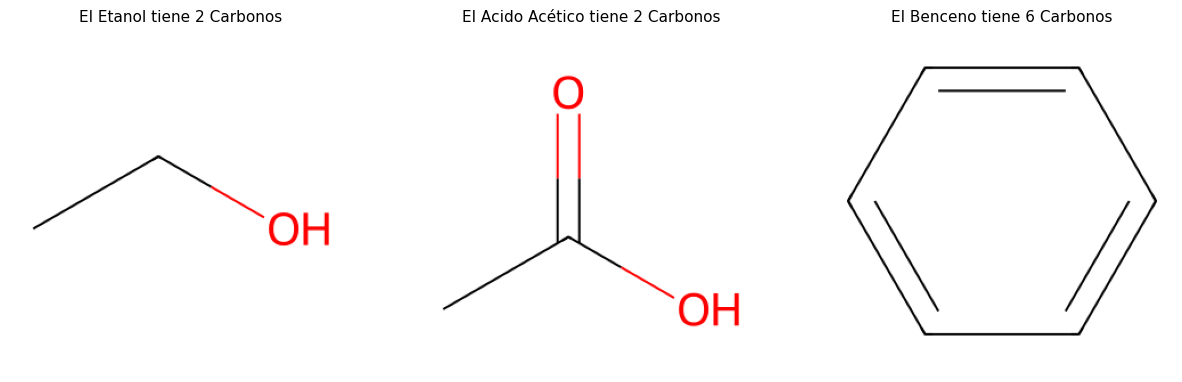

In [14]:
def calcular_num_carbonos(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_carbonos = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'C'])
        return num_carbonos
    else:
        return None       

def plot_molecula(smile):
    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol)
    return img
    
# Moleculas Test
EtanolSmile = "CCO"            
AcidoAceticoSmile = "CC(=O)O"  
BencenoSmile = "C1=CC=CC=C1"  
Etanol = calcular_num_carbonos(EtanolSmile)
AcidoAcetico = calcular_num_carbonos(AcidoAceticoSmile)      # Aplicar función a moleculas
Benceno = calcular_num_carbonos(BencenoSmile)
img_Etanol=plot_molecula(EtanolSmile)
img_AcidoAcetico=plot_molecula(AcidoAceticoSmile)            # Imagenes
img_Benceno=plot_molecula(BencenoSmile)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
axs[0].imshow(img_Etanol);axs[0].set_title(f"El Etanol tiene {Etanol} Carbonos",fontsize=11);axs[0].axis('off')                    # Etanol
axs[1].imshow(img_AcidoAcetico);axs[1].axis('off');axs[1].set_title(f"El Acido Acético tiene {AcidoAcetico} Carbonos",fontsize=11) # Ácido acético
axs[2].imshow(img_Benceno);axs[2].axis('off');axs[2].set_title(f"El Benceno tiene {Benceno} Carbonos",fontsize=11)                 # Benceno
plt.show() 

* #### Contar <b>Carbonos</b> en Df

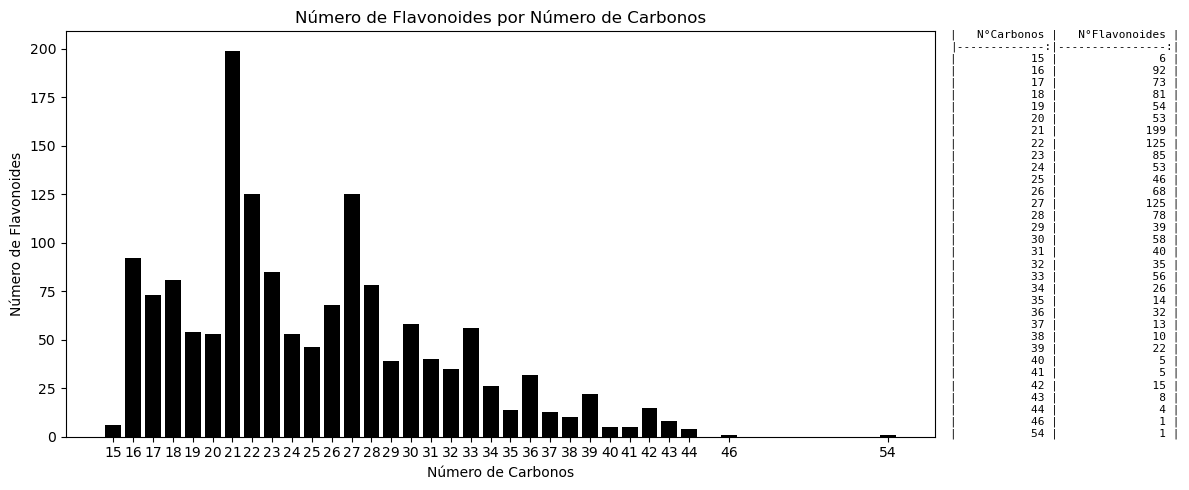

,ChEBI ID,ChEBI Name,SMILES,deltag,SID,CID,N°Carbonos
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,-9.4,85377015,131835070,22
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,-9.9,85390422,131752849,26
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,-10.3,85385648,44260005,28
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,-10.6,85395895,13916054,33
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,-9.0,85387578,11016019,22


In [16]:
df['N°Carbonos'] = df['SMILES'].apply(calcular_num_carbonos)        # Aplicar funcion al Df
grupos_por_carbonos = df.groupby('N°Carbonos').size()               # Group by Carbonos
dfgbcarbonos = grupos_por_carbonos.reset_index()                    # Df
dfgbcarbonos.columns = ["N°Carbonos", "N°Flavonoides"]
dfmdcarbono = dfgbcarbonos.to_markdown(index=False)                 # Markdown

# Plot
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[100, 1])  
ax1 = fig.add_subplot(gs[0]) 
ax1.bar(dfgbcarbonos['N°Carbonos'], dfgbcarbonos['N°Flavonoides'], color='black', width=0.8)                    
ax1.set_title('Número de Flavonoides por Número de Carbonos')                                                                           # Group by  C
ax1.set_xlabel('Número de Carbonos') ; ax1.set_xticks(dfgbcarbonos['N°Carbonos']) 
ax1.set_ylabel('Número de Flavonoides')
ax2 = fig.add_subplot(gs[1]); ax2.text(0, 0.5, dfmdcarbono, ha='left', va='center', fontsize=8, color='black', fontfamily='monospace')  # Markdown
ax2.axis('off')
#Mostrar  .axis('off')
plt.tight_layout()
plt.show()
df.head()

* #### Contar <span style="color:skyblue">Oxigenos</span> en Df:

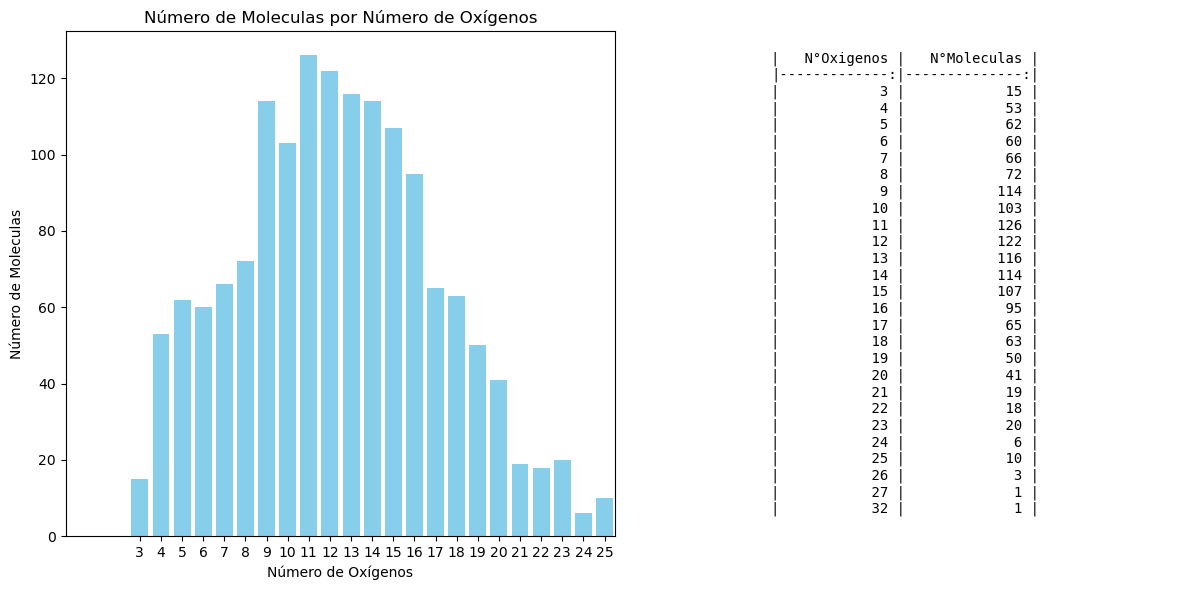

In [18]:
def calcular_num_oxigenos(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_oxigenos = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'O'])
        return num_oxigenos
    else:
        return None
    
df['N°Oxigenos'] = df['SMILES'].apply(calcular_num_oxigenos)    # Aplicar función a Df
grupos_por_oxigenos = df.groupby('N°Oxigenos').size()           # Group by  
df_resultado_oxigeno = grupos_por_oxigenos.reset_index()        # Df
df_resultado_oxigeno.columns = ["N°Oxigenos", "N°Moleculas"] 
df_resultado_md = df_resultado_oxigeno.to_markdown(index=False) # Markdown

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.bar(df_resultado_oxigeno['N°Oxigenos'], df_resultado_oxigeno['N°Moleculas'], color='skyblue')                       # Group by Oxigenos
ax1.set_xlabel('Número de Oxígenos') ; 
ax1.set_xticks(df_resultado_oxigeno['N°Oxigenos']);ax1.set_xlim(-0.5, len(df_resultado_oxigeno) - 0.5)
ax1.set_ylabel('Número de Moleculas')
ax1.set_title('Número de Moleculas por Número de Oxígenos')
ax2.text(0.5, 0.5, df_resultado_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')       # Markdown
ax2.axis('off')
plt.tight_layout() ; plt.show()

#### Contar otros átomos:
________________________________________________________________________________________

* #### Contar <span style="color: #E2725B;">Cu</span>

In [20]:
def calcular_num_cobre(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_cobre = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'Cu'])
        return num_cobre
    else:
        return None      
df['N°Cu'] = df['SMILES'].apply(calcular_num_cobre)           # Aplicar función a Df
grupos_por_cobre = df.groupby('N°Cu').size().reset_index()    # Group by Cu
grupos_por_cobre.columns = ["N°Cu", "N° Flavonoides"]        

# Mostrar
print("Resultados:")
print(grupos_por_cobre)                       # Group by
print("\n___________________________")
print("Df")
print("___________________________") 
print(df['N°Cu'].to_frame().sample(n=10))     # Imprimir la columna 'N°Cu'

Resultados:
   N°Cu  N° Flavonoides
0     0            1522

___________________________
Df
___________________________
      N°Cu
1135     0
1177     0
180      0
64       0
1320     0
332      0
38       0
1107     0
230      0
1387     0


* #### Contar  <span style="color:darkgray;">Fe</span>

In [22]:
def calcular_num_fierro(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_fierro = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'Fe'])
        return num_fierro
    else:
        return None
df['N°Fe'] = df['SMILES'].apply(calcular_num_fierro)               # Aplicar función al Df
grupos_por_fierro = df.groupby('N°Fe').size().reset_index()        # Group by Fe
grupos_por_fierro.columns = ["N°Fe", "N°Flavonoides"]
# Mostrar
print("Resultados:")
print(grupos_por_fierro)                   # Group by Fe
print("___________________________")
print("Df")
print("___________________________") 
print(df['N°Fe'].to_frame().sample(n=10))  # Columna 'N°Fe'

Resultados:
   N°Fe  N°Flavonoides
0     0           1522
___________________________
Df
___________________________
      N°Fe
48       0
6        0
660      0
1292     0
1306     0
1286     0
436      0
726      0
938      0
1368     0


* #### Contar  <span style="color:brown;">S</span>

In [24]:
def calcular_num_S(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_S = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'S'])
        return num_S
    else:
        return None
        
df['N°S'] = df['SMILES'].apply(calcular_num_S)         # Aplicar función al Df
grupos_por_S = df.groupby('N°S').size().reset_index()  # Group by S
grupos_por_S.columns = ["N°S", "N°Flavonoides"]
# Mostrar 
print("Resultados:")
print(grupos_por_S)                      # Group By
print("___________________________")
print("Df")
print("___________________________")
print(df['N°S'].to_frame().sample(n=10)) # Columna 'N°S' 

Resultados:
   N°S  N°Flavonoides
0    0           1450
1    1             66
2    2              6
___________________________
Df
___________________________
      N°S
1265    0
526     0
805     0
334     0
861     0
416     0
1377    1
880     0
123     0
872     0


* #### Contar  <span style="color:green;">N</span>

In [26]:
def calcular_num_N(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_N = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'N'])
        return num_N
    else:
        return None

df['N°N'] = df['SMILES'].apply(calcular_num_N)         # Aplicar función al Df
grupos_por_N = df.groupby('N°N').size().reset_index()  # Group by 
grupos_por_N.columns = ["N°N", "N° Flavonoides"]

# Mostrar 
print("Resultados:")
print(grupos_por_N)                        # Group By N
print("___________________________")
print("Df")
print("___________________________") 
print(df['N°N'].to_frame().sample(n=10)  )# Columna 'N°N'

Resultados:
   N°N  N° Flavonoides
0    0            1509
1    1              12
2    3               1
___________________________
Df
___________________________
      N°N
332     0
285     1
1107    0
1510    0
736     0
1496    0
909     0
810     0
1279    0
596     0


<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">

#### <i class="fas fa-trash-alt"></i> Eliminar columnas innecesarias

In [28]:
df = df.drop("N°Fe", axis=1)
df = df.drop("N°Cu", axis=1)
df.head()

,ChEBI ID,ChEBI Name,SMILES,deltag,SID,CID,N°Carbonos,N°Oxigenos,N°S,N°N
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,-9.4,85377015,131835070,22,14,0,0
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,-9.9,85390422,131752849,26,13,0,0
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,-10.3,85385648,44260005,28,17,0,0
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,-10.6,85395895,13916054,33,15,0,0
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,-9.0,85387578,11016019,22,11,0,0


### <span style="font-weight: bold; font-style: italic; text-decoration: wavy; font-size: 30px;">Anillos</span>
_____________________________________________________________________________________________________________________
 Los Flavonoides tienen anillos en su composición los cuales podemos contarlos y subclasificarlos de acuerdo a este criterio, esto es posible hacerlo mediante la función GetSymmSSSR: 
 
GetSymmSSSR es un método de la biblioteca RDKit que se utiliza para calcular los anillos simétricos más pequeños que rodean a los átomos de una molécula; SSSR significa "Smallest Set of Smallest Rings."
_____________________________________________________________________________________________________________________

<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">

### <i class="fas fa-microscope"></i> Test contar anillos:

Número de anillos en Naftaleno (C1=CC=C2C=CC=CC2=C1): 2


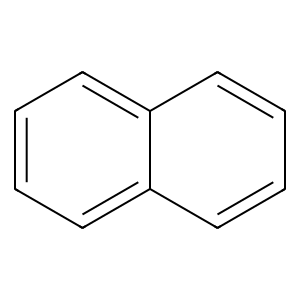

In [30]:
def mostrar_molecula (smile):
    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol)
    display(img)   
    
def contar_anillos(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_anillos = len(Chem.GetSymmSSSR(mol))  # Obtener el número de sistemas de anillos(SSSR)
        return num_anillos
    else:
        return "Error al procesar la molécula"     
# Test
naftaleno_smiles = "C1=CC=C2C=CC=CC2=C1"                                                  # Naftaleno
num_anillos_naftaleno = contar_anillos(naftaleno_smiles)                                  # Aplicar función al Df
print(f"Número de anillos en Naftaleno ({naftaleno_smiles}): {num_anillos_naftaleno}")
mostrar_molecula(naftaleno_smiles)

* #### Contar <span style="color:khaki;">Anillos</span> 

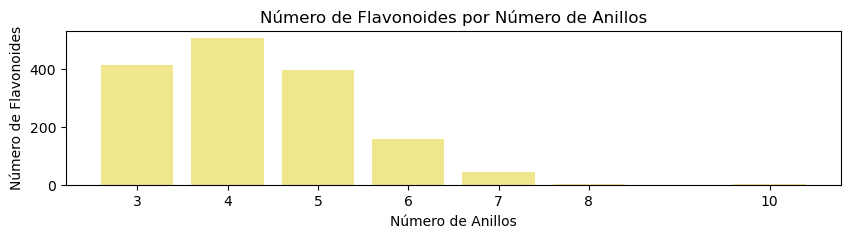

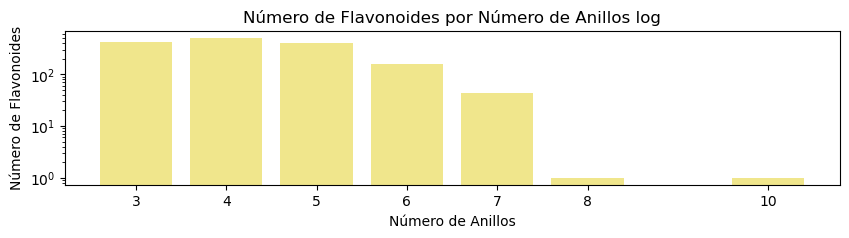

In [32]:
df['N°Anillos'] = df['SMILES'].apply(contar_anillos)    # Aplicar función al Df
grupos_por_anillos = df.groupby('N°Anillos').size()     # Group by

# Plot
plt.figure(figsize=(10, 2))  # Group by Anillos
plt.bar(grupos_por_anillos.index, grupos_por_anillos.values, color='khaki')
plt.xlabel('Número de Anillos');plt.ylabel('Número de Flavonoides'); plt.title('Número de Flavonoides por Número de Anillos')
plt.xticks(grupos_por_anillos.index) 
plt.show()
plt.figure(figsize=(10, 2))  # Escala log
plt.bar(grupos_por_anillos.index, grupos_por_anillos.values, color='khaki')
plt.title('Número de Flavonoides por Número de Anillos log')
plt.xlabel('Número de Anillos');plt.xticks(grupos_por_anillos.index);plt.ylabel('Número de Flavonoides');plt.yscale('log')
plt.show()


### <span style="font-weight: bold; font-style: italic; text-decoration: wavy; font-size: 30px;">Anillos aromáticos</span>

_____________________________________________________________________________________________________________

 RDkit nos permite crear formulas para detectar la aromaticidad de los anillos de nuestras moleculas
###### Fuente : https://sourceforge.net/p/rdkit/mailman/message/23801106/
___________________________________________________________________________________________________________________________________________________

<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">

### <i class="fas fa-microscope"></i> Test contar anillos aromáticos:

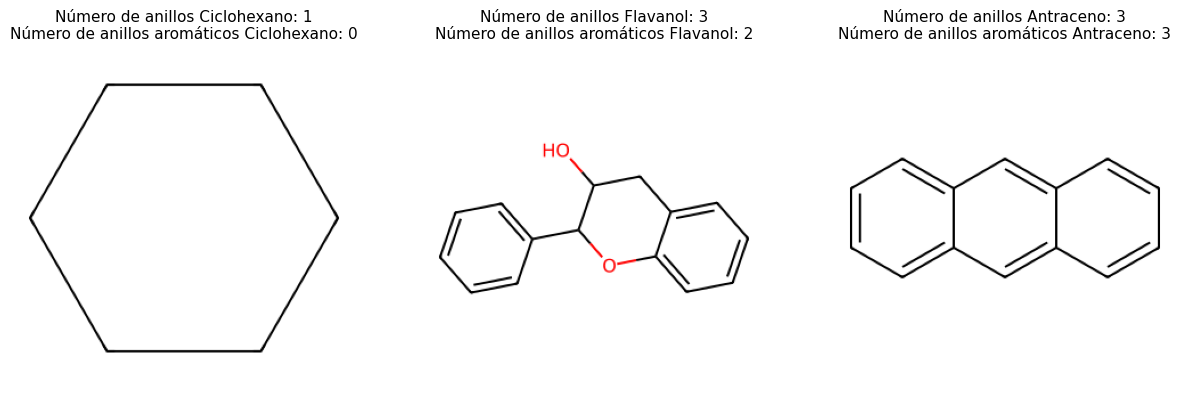

In [36]:
def contar_aromaticos(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return "Error al procesar la molécula"
    ring_info = mol.GetRingInfo()
    atom_rings = ring_info.AtomRings()
    bond_rings = ring_info.BondRings()
    anillos_aromaticos = 0
    for bond_ring in bond_rings:
        aromatico = True
        for bond_idx in bond_ring:
            if not mol.GetBondWithIdx(bond_idx).GetIsAromatic():
                aromatico = False
                break
        if aromatico:
            anillos_aromaticos += 1
    return anillos_aromaticos
    
#Moleculas Test 
#----------------------------------------Ciclohexano
Ciclohexanosmile = 'C1CCCCC1'  
imagenciclohexano = plot_molecula(Ciclohexanosmile)
anillos_ciclohexano = contar_anillos(Ciclohexanosmile)
aromaticos_ciclohexano = contar_aromaticos(Ciclohexanosmile)
#----------------------------------------Flavonol
Flavonolsmile = "C1C(C(OC2=CC=CC=C21)C3=CC=CC=C3)O"
imagenflavonol = plot_molecula(Flavonolsmile)
anillos_flavonol = contar_anillos(Flavonolsmile)
aromaticos_flavonol = contar_aromaticos(Flavonolsmile)
#----------------------------------------Antraceno
Antracenosmile = "C1=CC2=CC3=CC=CC=C3C=C2C=C1"
imagenantraceno = plot_molecula(Antracenosmile)
anillos_antraceno = contar_anillos(Antracenosmile)
aromaticos_antraceno = contar_aromaticos(Antracenosmile)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
axs[0].imshow(imagenciclohexano)      # Flavanona
axs[0].set_title(f"Número de anillos Ciclohexano: {anillos_ciclohexano}\nNúmero de anillos aromáticos Ciclohexano: {aromaticos_ciclohexano}", fontsize=11)
axs[1].imshow(imagenflavonol)         # Flavanol
axs[1].set_title(f"Número de anillos Flavanol: {anillos_flavonol}\nNúmero de anillos aromáticos Flavanol: {aromaticos_flavonol}",fontsize=11)
axs[2].imshow(imagenantraceno)        # Antraceno
axs[2].set_title(f"Número de anillos Antraceno: {anillos_antraceno}\nNúmero de anillos aromáticos Antraceno: {aromaticos_antraceno}",fontsize=11)
for ax in axs:
    ax.axis('off')
plt.show()

* #### Contar  <span style="color:lightgreen;">Anillos aromáticos</span> 

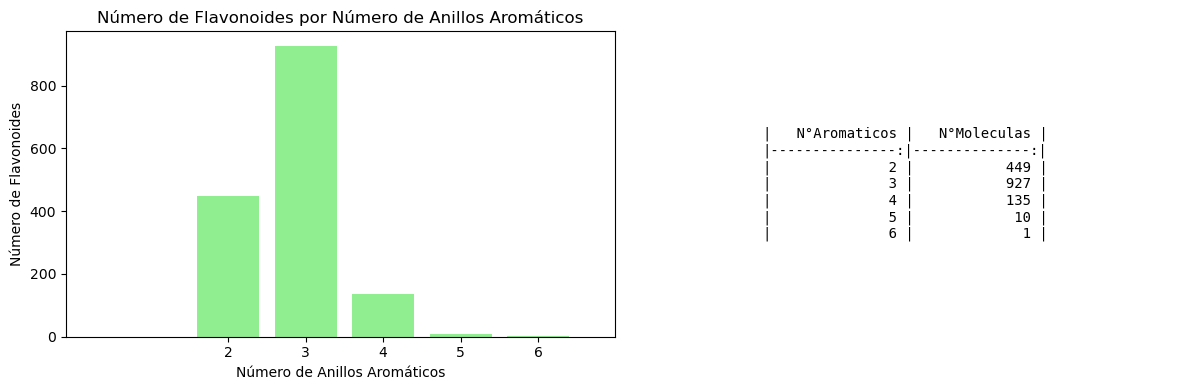

In [38]:
df['N°Aromaticos'] = df['SMILES'].apply(contar_aromaticos)              # Aplicar función al Df
grupos_por_aromaticos = df.groupby('N°Aromaticos').size()               # Group by 
df_resultado_aromatico = grupos_por_aromaticos.reset_index()            # Df
df_resultado_aromatico.columns = ["N°Aromaticos", "N°Moleculas"]
df_resultado_md = df_resultado_aromatico.to_markdown(index=False)       # Markdown

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.bar(df_resultado_aromatico['N°Aromaticos'], df_resultado_aromatico['N°Moleculas'], color='lightgreen') # Group by N° Anillos Aromáticos 
ax1.set_title('Número de Flavonoides por Número de Anillos Aromáticos')
ax1.set_xlabel('Número de Anillos Aromáticos');ax1.set_ylabel('Número de Flavonoides'); ax1.set_xticks(df_resultado_aromatico['N°Aromaticos'])
ax1.set_xlim(-0.1, len(df_resultado_aromatico) + 2)
ax2.text(0.5, 0.5, df_resultado_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace') # Markdwon
ax2.axis('off')
plt.tight_layout();plt.show()

# Clasificación por <span style="font-weight: bold; font-style: italic; text-decoration: wavy; font-size: 30px;">subestructuras</span>
Gracias a RDkit podemos clasificar nuestro dataframe segun las estructuras primarias de los flavonoides
Álvarez Castro, E., & Orallo Cambeiro, F. (2003). Actividad biológica de los flavonoides (I). Acción frente al cáncer. Offarm, 22(10), 130–140. https://www.elsevier.es/es-revista-offarm-4-articulo-actividad-biologica-flavonoides-i-accion-13054406
____________________________________________________________________________________________________________________________________


<span style="font-weight: bold; font-style: italic; text-decoration: wavy; font-size: 35px;">Isoflavonas</span>


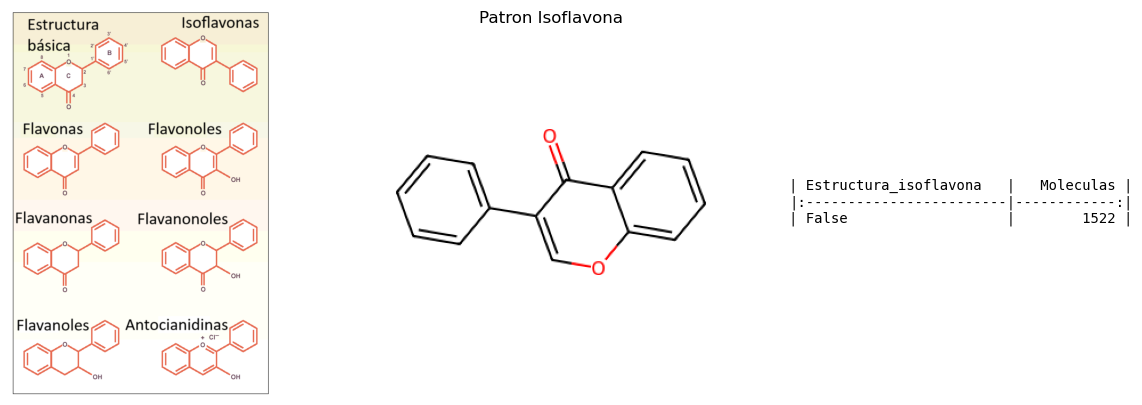

In [41]:
from PIL import Image
def verificar_isoflavona(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_isoflavona)
    else:
        return False 

#Patron Isoflavona
smiles_isoflavona = "C1=CC=C(C=C1)C2=COC3=CC=CC=C3C2=O"
imagen_isoflavona = plot_molecula(smiles_isoflavona)
patron_isoflavona = Chem.MolFromSmiles(smiles_isoflavona)
df['Estructura_isoflavona'] = df['SMILES'].apply(verificar_isoflavona)   # Aplicar función a Df
grupo_isoflavona = df.groupby('Estructura_isoflavona').size()            # Group by Estructura_isoflavona
grupo_isoflavona_md = grupo_isoflavona.reset_index().rename(columns={0: 'Moleculas'}).to_markdown(index=False)   # Markdwon
ruta_imagen = "imgs/flavsimg.png"  # Imagen
imagen = Image.open(ruta_imagen)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 
axs[0].imshow(imagen)                  # Estructura Flavonoides
axs[1].imshow(imagen_isoflavona)       # Isoflavona
axs[1].set_title("Patron Isoflavona")
axs[2].text(0.5, 0.5, grupo_isoflavona_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace') # Markdown
for ax in axs:
    ax.axis('off')
plt.show()

<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">

### <i class="fas fa-microscope"></i> Test detectar estructura Isoflavona:
Ya que no se detectaron Isoflavonas en el  Df vamos a testear nuestra función con distintas moleculas:
###### (Apretar botón actualizar para probar distintas moleculas)

In [43]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import random

def actualizar_grafico(b):
    with output_estructura_isoflavona:
        clear_output(wait=True)
        smiles_molecula_aleatoria = random.choice(moleculas)              
        imagen_test_isoflavona = plot_molecula(smiles_molecula_aleatoria) # Test
        es_isoflavona = verificar_isoflavona(smiles_molecula_aleatoria)

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(15, 3)) 
        axs[0].imshow(imagen_isoflavona);axs[0].set_title("Isoflavona")  # Isoflavona
        axs[1].imshow(imagen_test_isoflavona);axs[1].set_title(f"Test Isoflavona: {es_isoflavona}") # Test
        for ax in axs:
            ax.axis('off')
        plt.tight_layout();display(fig);plt.close(fig)
        
# Lista de moléculas TEST
moleculas = [
    "C1CC2=C(C1)C(=O)C3=C(C2=O)C=C(C=C3)O",
    "C1=CC=C(C=C1)C2=COC3=C2C=CC(=C3)O",
    "COC1=CC=C(C=C1)C2=COC3=C(C2=O)C=CC(=C3)O",
    "OC1=CC=C(C=C1)C1=COC2=CC(O)=CC(O)=C2C1=O",
    "C1=CC=CC=C1",
     "C1=CC=C2C=CC=CC2=C1",
    "COC1=C(C=C2C(=C1)C(=O)C(=CO2)C3=CC=C(C=C3)O)O"
]

# Widget
output_estructura_isoflavona = widgets.Output()
boton_actualizar = widgets.Button(# Botón
    description="Actualizar",                              
    layout=widgets.Layout(width='78.75%')  
)
boton_actualizar.on_click(actualizar_grafico)    
display(boton_actualizar,output_estructura_isoflavona);actualizar_grafico(None)  

Button(description='Actualizar', layout=Layout(width='78.75%'), style=ButtonStyle())

Output()

### <span style="font-weight: bold; font-style: italic; text-decoration: wavy; font-size: 35px;">Isoflavanona</span>

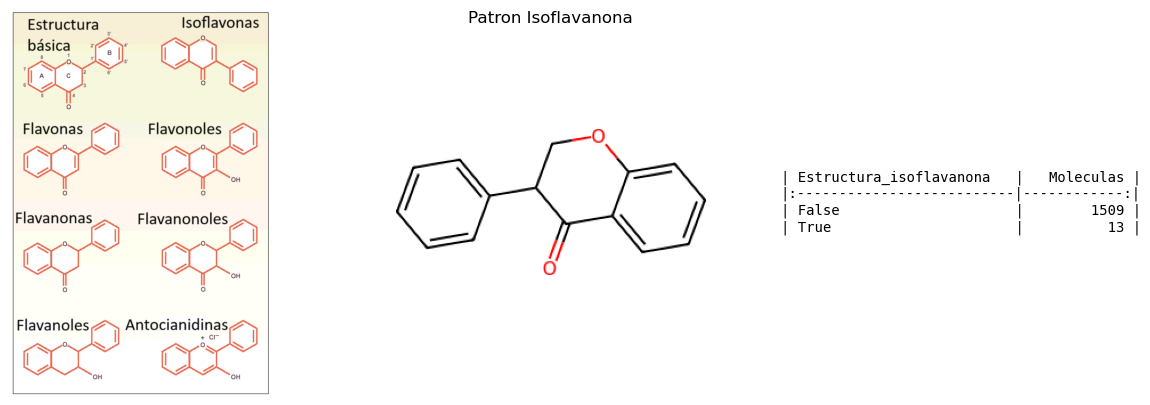

In [45]:
def verificar_isoflavanona(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_isoflavanona)
    else:
        return False  
        
#Patron Isoflavona
smiles_isoflavanona = "C1C(C(=O)C2=CC=CC=C2O1)C3=CC=CC=C3"
imagen_isoflavanona = plot_molecula(smiles_isoflavanona)
patron_isoflavanona = Chem.MolFromSmiles(smiles_isoflavanona)
df['Estructura_isoflavanona'] = df['SMILES'].apply(verificar_isoflavanona)                                            # Aplicar la función a Df
grupo_isoflavanona = df.groupby('Estructura_isoflavanona').size()                                                     # Group by
grupo_isoflavanona_md = grupo_isoflavanona.reset_index().rename(columns={0: 'Moleculas'}).to_markdown(index = False)  # Markdown

#Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
ruta_imagen = "imgs/flavsimg.png"
imagen = Image.open(ruta_imagen)
axs[0].imshow(imagen)                                                                                                      # Referencia estructuras
axs[1].imshow(imagen_isoflavanona); axs[1].set_title("Patron Isoflavanona")                                                # Isoflavanona
axs[2].text(0.5, 0.5, grupo_isoflavanona_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace') # Markdown
for ax in axs:
    ax.axis('off')
plt.show()

* #### Si Estructura_isoflavanona = True nombramos como isoflavanona nuestras moleculas

In [47]:
df['Tipo_flavonoide'] = ''                                                        # Crear columna vacía
valor_actual = df['Tipo_flavonoide']                                              # Mantener mismo valor si no se cumple condicion 
indices_isoflavanona = df[df['Estructura_isoflavanona'] == True].index.tolist()   # Índices de Isoflavanonas

# Condiciones
condiciones = [
    (df['Estructura_isoflavanona'] == True)
]
# Valores
valores = ['Isoflavanona']
# Asignar valores
df['Tipo_flavonoide'] = np.select(condiciones, valores, default=valor_actual)
df.loc[indices_isoflavanona, ['SMILES', 'ChEBI Name', 'Estructura_isoflavanona', 'Tipo_flavonoide']].sample(n=10) # Mostrar

,SMILES,ChEBI Name,Estructura_isoflavanona,Tipo_flavonoide
41,O1CC(C2=CC=C(OC)C=C2)C(=O)C3=C1C=C(O)C=C3,Dihydroformononetin,True,Isoflavanona
897,O1CC(C2=C(OC)C=C(O)C=C2)C(=O)C=3C1=CC(O)=CC3O,Isoferreirin,True,Isoflavanona
10,O1CC(C(=O)C2=C1C(=C(OC)C=C2O)C)C3=CC(OC)=CC=C3,5-hydroxy-7-methoxy-3-(3-methoxyphenyl)-8-meth...,True,Isoflavanona
538,O1CC(C(=O)C=2C1=C(C(O)=CC2O)C)C3=CC=C(OC)C=C3,"5,7-Dihydroxy-4'-methoxy-8-methylisoflavanone",True,Isoflavanona
1069,O1CC(C(=O)C=2C1=CC(O)=C(OC)C2)C3=CC=C(O)C=C3,Dihydroglycitein,True,Isoflavanona
1322,C=1(C=C(C2=C(C1)OCC(C2=O)C=3C(=C(C(=CC3)O)OC)O...,parvisoflavanone,True,Isoflavanona
1353,O1CC(C2=C(OC)C(OC)=C(O)C=C2)C(=O)C3=C1C=C(O)C=C3,Lespedeol C,True,Isoflavanona
1033,O1CC(C=2C(OC)=CC=3OCOC3C2)C(=O)C=4C1=CC(O)=CC4O,Cicerin,True,Isoflavanona
301,O1CC(C2=C(OC)C=C(O)C=C2)C(=O)C3=C1C=C(O)C=C3OC,"4',7-Dihydroxy-2',5-dimethoxyisoflavanone",True,Isoflavanona
1495,O1CC(O)(C2=C(O)C=C(OC)C=C2)C(=O)C3=C1C=C(O)C=C3,"4'-Methoxy-2',3,7-trihydroxyisoflavanone",True,Isoflavanona


<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">

### <i class="fas fa-microscope"></i> Test clasificación Isoflavanona:
 Vemos si nuestras moleculas ya clasificadas como Isoflavanonas cumplen con la clasificación

In [49]:
def actualizar_test_isoflavanona(b):
    with output_clasificación_isoflavanona:
        clear_output(wait=True)
        test_isoflavanona = random.choice(indices_isoflavanona)                                # Isoflavanona aleatoria
        print(df.loc[test_isoflavanona, ['SMILES', 'ChEBI Name', 'Estructura_isoflavanona']])  # Mostrar
        smiles_isoflavanonas = df.loc[test_isoflavanona, 'SMILES']
        imagen_test_isoflavanona = plot_molecula(smiles_isoflavanonas)
        
        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(15, 3))  
        axs[0].imshow(imagen_isoflavanona);axs[0].set_title("Isoflavanona")                    # Isoflavanona
        axs[1].imshow(imagen_test_isoflavanona);axs[1].set_title("Isoflavanona clasificada:")  # Test
        for ax in axs :
            ax.axis('off')
        plt.tight_layout();display(fig);plt.close(fig) # Mostrar

#Widget
output_clasificación_isoflavanona = widgets.Output()
boton_actualizar = widgets.Button(# Botón
    description="Actualizar",
    layout=widgets.Layout(width='78.75%')
)
boton_actualizar.on_click(actualizar_test_isoflavanona)
display(boton_actualizar);display(output_clasificación_isoflavanona);actualizar_test_isoflavanona(None) # Mostrar

Button(description='Actualizar', layout=Layout(width='78.75%'), style=ButtonStyle())

Output()

<details>
<summary style="font-weight:bold; font-size:24px;">Flavonas y Flavonoles</summary>
Flavonas y Flavonoles comparten el mismo esqueleto, por lo que teóricamente deberíamos encontrar más Flavonas que Flavonoles.

</details>
<span style="font-weight: bold; font-style: italic; text-decoration: wavy; font-size: 35px;">Flavonas</span>

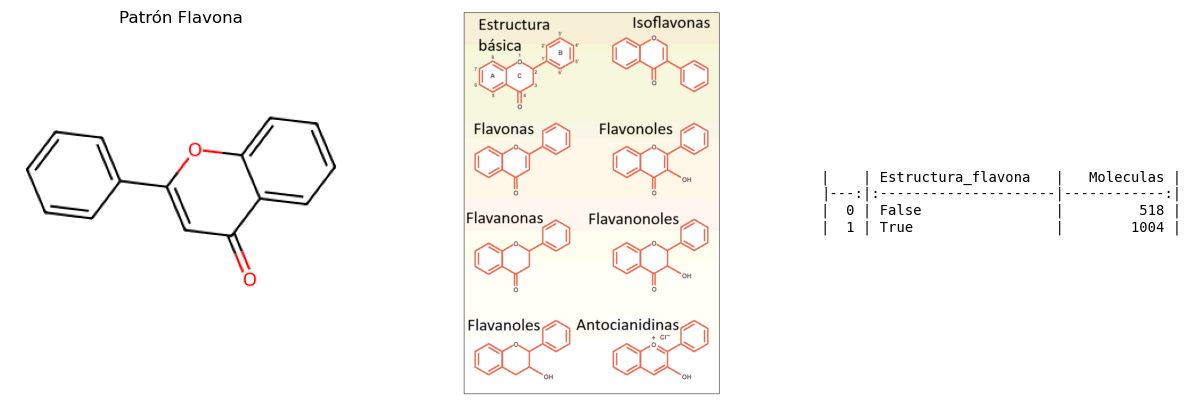

In [51]:
def verificar_flavona(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavona)
    else:
        return False  

# Patron Flavona
smiles_flavona = "C1=CC=C(C=C1)C2=CC(=O)C3=CC=CC=C3O2"
imagen_flavona = plot_molecula(smiles_flavona)
patron_flavona = Chem.MolFromSmiles(smiles_flavona)
df['Estructura_flavona'] = df['SMILES'].apply(verificar_flavona)                              # Aplicar la función al Df
grupo_flavona = df.groupby('Estructura_flavona').size()                                       # Group by 
grupo_flavona_md = grupo_flavona.reset_index().rename(columns={0: 'Moleculas'}).to_markdown() # Markdwon

# Plot
imagen = Image.open(ruta_imagen) # Imagen referencia
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
axs[0].set_title("Patrón Flavona");axs[0].imshow(imagen_flavona)                                                      # Flavona
axs[1].imshow(imagen)                                                                                                 # Referencia subestructuras
axs[2].text(0.5, 0.5, grupo_flavona_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace') # Markdown
for ax in axs:
    ax.axis('off')
plt.show()

### <span style="font-weight: bold; font-style: italic; text-decoration: wavy; font-size: 35px;">Flavonol</span>

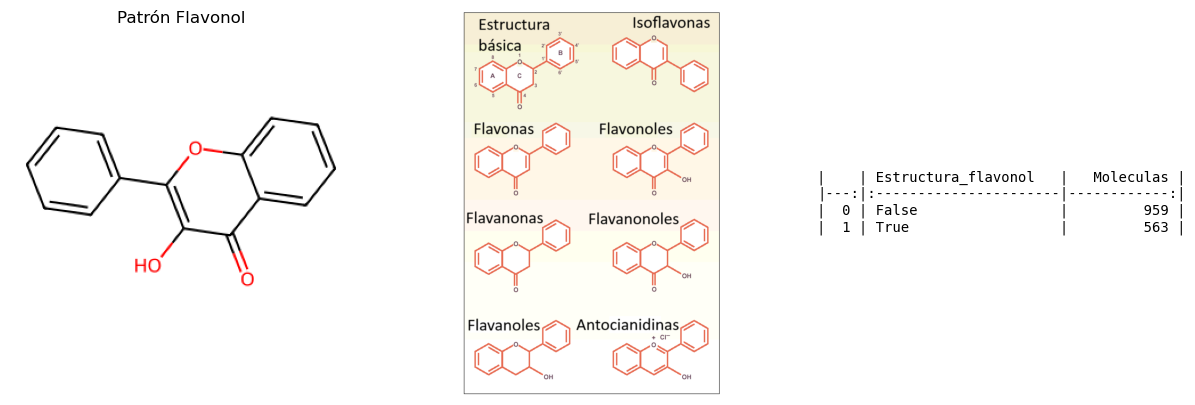

In [55]:
def verificar_flavonol(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavonol)
    else:
        return False  

# Patron Flavonol
smiles_flavonol =("C1=CC=C(C=C1)C2=C(C(=O)C3=CC=CC=C3O2)O")
imagen_flavonol = plot_molecula(smiles_flavonol)
patron_flavonol = Chem.MolFromSmiles(smiles_flavonol)

df['Estructura_flavonol'] = df['SMILES'].apply(verificar_flavonol)                                # Aplicar la función al Df
grupo_flavonol = df.groupby('Estructura_flavonol').size()                                         # Group by 
grupo_flavonol_md = grupo_flavonol.reset_index().rename(columns={0: 'Moleculas'}).to_markdown()   # Markdown 

# Plot
imagen = Image.open(ruta_imagen)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
axs[0].set_title("Patrón Flavonol");axs[0].imshow(imagen_flavonol                                                   )  #Flavonol
axs[1].imshow(imagen)                                                                                                  # Referencia subestructuras
axs[2].text(0.5, 0.5, grupo_flavonol_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace') # Markdown
for ax in axs:
    ax.axis('off')
plt.show()

* ##### De esta manera si Estructura_flavona = True & Estructura_flavonol = False entonces la molecula es Flavona
* ##### Por el contrario si Estructura_flavona = True & Estructura_flavonol = True entonces la molecula es Flavonol
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">

### <i class="fas fa-microscope"></i> Muestra Df
###### ("Actualizar" para generar nueva muestra del df)

In [59]:
def actualizar_muestra_df(b):
    with output_actualizar_muestra_df:
        clear_output(wait=True)
        display(df[['Estructura_flavona', 'Estructura_flavonol', 'Tipo_flavonoide']].sample(n=10))
valor_actual = df['Tipo_flavonoide']

#Condiciones
condiciones = [
    (df['Estructura_flavona'] == True) & (df['Estructura_flavonol'] == False),
    (df['Estructura_flavona'] == True) & (df['Estructura_flavonol'] == True)
]

# Valores 
valores = ['Flavona', 'Flavonol']
df['Tipo_flavonoide'] = np.select(condiciones, valores, default=valor_actual) # Asignar valores a 'Tipo_flavonoide'

# Widget
output_actualizar_muestra_df = widgets.Output()
boton_actualizar = widgets.Button(# Botón
    description="Actualizar",
    layout=widgets.Layout(width='37.5%')
)
boton_actualizar.on_click(actualizar_muestra_df)
display(boton_actualizar);display(output_actualizar_muestra_df);actualizar_muestra_df(None) # Mostrar

Button(description='Actualizar', layout=Layout(width='37.5%'), style=ButtonStyle())

Output()

<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">

### <i class="fas fa-microscope"></i> Test Flavonas clasificadas:


In [63]:
def actualizar_test_flavona(b):
    with output_test_flavona:
        clear_output(wait=True)
        indices_flavona = df[df['Tipo_flavonoide'] == 'Flavona'].index.tolist()     # Indice Flavona aleatoria
        test_flavona = random.choice(indices_flavona)                               # Flavona aleatoria
        smiles_molecula_flavona = df.loc[test_flavona, 'SMILES']
        imagen_flavona_test = plot_molecula(smiles_molecula_flavona)
        print(df.loc[test_flavona, ['SMILES', 'ChEBI Name', 'Estructura_flavona']]) # Info Molecula

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(15, 3))  
        axs[0].imshow(imagen_flavona);axs[0].set_title("Flavona")                   # Isoflavona
        axs[1].imshow(imagen_flavona_test);axs[1].set_title("Test Flavona")         # Test
        for ax in axs:
            ax.axis('off')
        plt.tight_layout();display(fig);plt.close(fig) # Mostrar 

# Widget
output_test_flavona = widgets.Output()
boton_actualizar = widgets.Button(# Botón
    description="Actualizar",
    layout=widgets.Layout(width='78.75%')
)
boton_actualizar.on_click(actualizar_test_flavona)
display(boton_actualizar);display(output_test_flavona);actualizar_test_flavona(None) # Mostrar

Button(description='Actualizar', layout=Layout(width='78.75%'), style=ButtonStyle())

Output()

<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">

### <i class="fas fa-microscope"></i> Test Flavonoles clasificados:

In [66]:
def actualizar_test_flavonol(b):
    with output_test_flavonol:
        clear_output(wait=True)
        indices_flavonol = df[df['Tipo_flavonoide'] == 'Flavonol'].index.tolist()      # Índices Flavonol aleatorio
        test_flavonol = random.choice(indices_flavonol)                                #Flavonol aleatorio
        smiles_molecula_flavonol = df.loc[test_flavonol, 'SMILES']
        imagen_flavonol_test = plot_molecula(smiles_molecula_flavonol)
        print(df.loc[test_flavonol, ['SMILES', 'ChEBI Name', 'Estructura_flavonol']])  # Info molecula

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(15, 3))  
        axs[0].imshow(imagen_flavonol);axs[0].set_title("Flavonol")           # Isoflavona
        axs[1].imshow(imagen_flavonol_test);axs[1].set_title("Test Flavonol") # Test
        for ax in axs:
            ax.axis('off')
        plt.tight_layout();display(fig);plt.close(fig) # Mostrar 

# Widget
output_test_flavonol = widgets.Output()
boton_actualizar = widgets.Button(# Botón
    description="Actualizar",
    layout=widgets.Layout(width='78.75%')
)
boton_actualizar.on_click(actualizar_test_flavonol)
display(boton_actualizar);display(output_test_flavonol);actualizar_test_flavonol(None) # Mostrar

Button(description='Actualizar', layout=Layout(width='78.75%'), style=ButtonStyle())

Output()

<details>
<summary style="font-weight:bold; font-size:24px;">Flavanonas y Flavanonoles</summary>
 Al igual que las Flavonas y Flavonoles, las  Flavanonas y Flavanonoles tambien comparten el mismo esqueleto, por lo que teoricamente debemos encontrar mas Flavanonas que Flavanonoles 
</details>

<span style="font-weight: bold; font-style: italic; text-decoration: wavy; font-size: 35px;">Flavanonas</span>

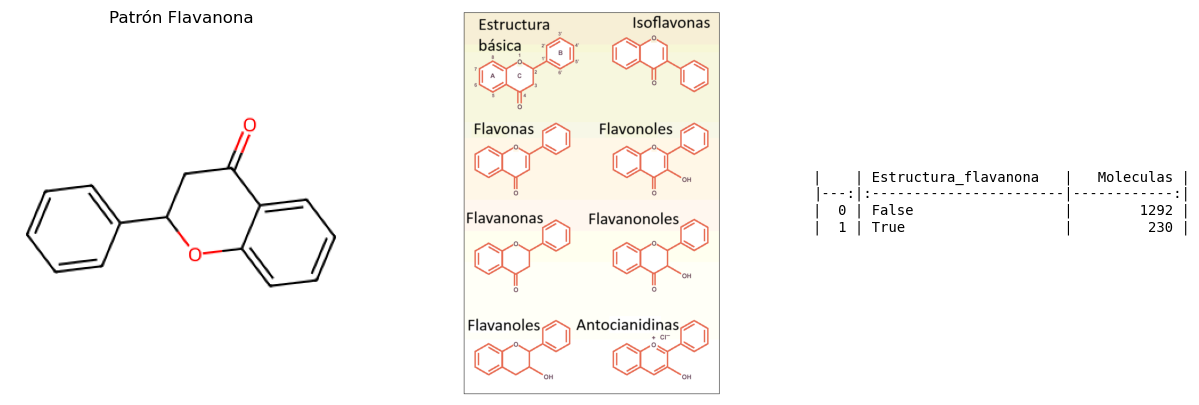

In [68]:
def verificar_flavanona(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavanona)
    else:
        return False  

# Patron Flavanona
smiles_flavanona =("C1C(OC2=CC=CC=C2C1=O)C3=CC=CC=C3")
imagen_flavanona = plot_molecula(smiles_flavanona)
patron_flavanona = Chem.MolFromSmiles(smiles_flavanona)
df['Estructura_flavanona'] = df['SMILES'].apply(verificar_flavanona)                              # Aplicar la función al Df
grupo_flavanona = df.groupby('Estructura_flavanona').size()                                       # Group by 
grupo_flavanona_md = grupo_flavanona.reset_index().rename(columns={0: 'Moleculas'}).to_markdown() # Markdown

#Plot
imagen = Image.open(ruta_imagen)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
axs[0].set_title("Patrón Flavanona");axs[0].imshow(imagen_flavanona)                                                    # Flavanona
axs[1].imshow(imagen)                                                                                                   # Referencia subestructuras
axs[2].text(0.5, 0.5, grupo_flavanona_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace') #"Markdown"
for ax in axs:
    ax.axis('off') 
plt.show()

### <span style="font-weight: bold; font-style: italic; text-decoration: wavy; font-size: 35px;">Flavanonoles</span>

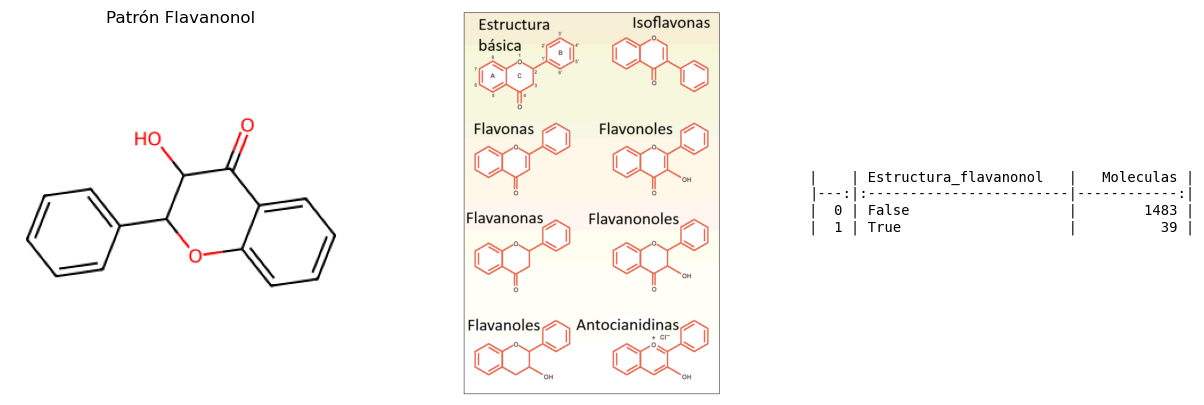

In [70]:
def verificar_flavanonol(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavanonol)
    else:
        return False 
        
# Patron Flavanonol
smiles_flavanonol =("C1(O)C(OC2=CC=CC=C2C1=O)C3=CC=CC=C3")
patron_flavanonol = Chem.MolFromSmiles(smiles_flavanonol)
imagen_flavanonol = plot_molecula(smiles_flavanonol)
df['Estructura_flavanonol'] = df['SMILES'].apply(verificar_flavanonol)                              # Aplicar la función al Df
grupo_flavanonol = df.groupby('Estructura_flavanonol').size()                                       # Group by 
grupo_flavanonol_md = grupo_flavanonol.reset_index().rename(columns={0: 'Moleculas'}).to_markdown() # Markdown

# Plot
imagen = Image.open(ruta_imagen)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
axs[0].set_title("Patrón Flavanonol");axs[0].imshow(imagen_flavanonol)                                                   # Flavanonol
axs[1].imshow(imagen)                                                                                                    # Referencia subestructuras
axs[2].text(0.5, 0.5, grupo_flavanonol_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace') # Markdown
for ax in axs:
    ax.axis('off')
plt.show() # Mostrar

* ##### Si Estructura_flavanona = True & Estructura_flavanonol = False entonces la molecula es Flavanona
* ##### Por el contrario si Estructura_flavanona = True & Estructura_flavanonol = True entonces la molecula es Flavanonol
### <i class="fas fa-microscope"></i> Muestra Df

###### ("Actualizar" para generar nueva muestra del df)

In [72]:
def actualizar_muestra_df_2(b):
    with output_muestra_df_2:
        clear_output(wait=True)
        display(df[['Estructura_flavanona', 'Estructura_flavanonol', 'Tipo_flavonoide']].sample(n=10)) # Mostrar una muestra del DataFrame

valor_actual = df['Tipo_flavonoide']

#Condiciones
condiciones = [
    (df['Estructura_flavanona'] == True) & (df['Estructura_flavanonol'] == False),
    (df['Estructura_flavanona'] == True) & (df['Estructura_flavanonol'] == True)
]

# Valores 
valores = ['Flavanona', 'Flavanonol']
df['Tipo_flavonoide'] = np.select(condiciones, valores, default=valor_actual) # Asignar valores a la columna 'Tipo_flavonoide'

# Widget 
output_muestra_df_2 = widgets.Output()
boton_actualizar = widgets.Button( # Botón
    description="Actualizar",             
    layout=widgets.Layout(width='37.5%')
)
boton_actualizar.on_click(actualizar_muestra_df_2)
display(boton_actualizar, output_muestra_df_2), actualizar_muestra_df_2(None)  # Mostrar

Button(description='Actualizar', layout=Layout(width='37.5%'), style=ButtonStyle())

Output()

(None, None)

### <i class="fas fa-microscope"></i> Test clasificacion Flavanona


In [74]:
def actualizar_test_flavanona(b):
    with output_test_flavanona:
        clear_output(wait=True)
        indices_flavanona = df[df['Tipo_flavonoide'] == 'Flavanona'].index.tolist()     # Índices Flavanona
        test_flavanona = random.choice(indices_flavanona)                               # Flavanona aleatoria
        smiles_molecula_flavanona = df.loc[test_flavanona, 'SMILES']
        imagen_flavanona_test = plot_molecula(smiles_molecula_flavanona)
        print(df.loc[test_flavanona, ['SMILES', 'ChEBI Name', 'Estructura_flavanona']])  # Info Molecula

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(15, 3))  
        axs[0].imshow(imagen_flavanona);axs[0].set_title("Flavanona")           # Flavanona
        axs[1].imshow(imagen_flavanona_test);axs[1].set_title("Test Flavanona") # Test
        for ax in axs:
            ax.axis('off')
        plt.tight_layout();display(fig); plt.close(fig)   # Mostrar 

# Widget
output_test_flavanona = widgets.Output()
boton_actualizar = widgets.Button(# Botón
    description="Actualizar",
    layout=widgets.Layout(width='78.75%')
)
boton_actualizar.on_click(actualizar_test_flavanona)
display(boton_actualizar);display(output_test_flavanona);actualizar_test_flavanona(None) # Mostrar

Button(description='Actualizar', layout=Layout(width='78.75%'), style=ButtonStyle())

Output()

<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">

### <i class="fas fa-microscope"></i> Test clasificacion Flavanonol


In [76]:
def actualizar_test_flavanonol(b):
    with output_test_flavanonol:
        clear_output(wait=True)
        indices_flavanonol = df[df['Tipo_flavonoide'] == 'Flavanonol'].index.tolist()     #Índices Flavanonol
        test_flavanonol = random.choice(indices_flavanonol)                               #Test Flavanompñ aleatorio
        smiles_molecula_flavanonol = df.loc[test_flavanonol, 'SMILES']
        imagen_flavanonol_test = plot_molecula(smiles_molecula_flavanonol)
        print(df.loc[test_flavanonol, ['SMILES', 'ChEBI Name', 'Estructura_flavanonol']]) # Info Molecula

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(15, 3))  
        axs[0].imshow(imagen_flavanonol);axs[0].set_title("Flavanonol")                   # Isoflavona
        axs[1].imshow(imagen_flavanonol_test); axs[1].set_title("Test Flavanonol")        # Test
        for ax in axs:
            ax.axis('off')
        plt.tight_layout(); display(fig);plt.close(fig) # Mostrar

# Widget
output_test_flavanonol = widgets.Output()
boton_actualizar = widgets.Button(# Botón
    description="Actualizar",
    layout=widgets.Layout(width='78.75%')
)
boton_actualizar.on_click(actualizar_test_flavanonol)
display(boton_actualizar);display(output_test_flavanonol);actualizar_test_flavanonol(None) # Mostrar

Button(description='Actualizar', layout=Layout(width='78.75%'), style=ButtonStyle())

Output()

* #### Revisamos una muestra de nuestro dataframe y contamos las moleculas que nos quedan sin clasificar:

In [79]:
df[['ChEBI Name', 'SMILES', 'Tipo_flavonoide']].sample(n=10)

,ChEBI Name,SMILES,Tipo_flavonoide
691,Mosloflavone,O1C=2C(=C(O)C(OC)=C(OC)C2)C(=O)C=C1C3=CC=CC=C3,Flavona
609,"3,4,5-trihydroxy-6-{[5-methoxy-2,2-dimethyl-6-...",CC1(C)C=CC2=C(C=C(C(/C=C/C(C3=CC=CC=C3)=O)=C2O...,
480,Gossypetin 3-sophoroside-8-glucoside,O(C1C(O)[C@H](O)C(O[C@H]1OC2=C(OC=3C(O[C@@H]4O...,Flavonol
838,Hispidulin 7-(6''-E-p-Coumaroylglucoside),O1C([C@@H](O)[C@H](O)C(O)[C@@H]1OC2=C(OC)C(O)=...,Flavona
834,Rhamnocitrin 3-rhamnoside,O1[C@H]([C@H](O)[C@@H](O)[C@@H](O)[C@@H]1OC2=C...,Flavonol
375,"2-(3,4-dihydroxyphenyl)-5,7-dihydroxy-4-oxo-4H...",[C@@H]1([C@@H]([C@@](CO1)(O)CO)O)O[C@H]2[C@H](...,Flavonol
61,Tagetiin,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC2=...,Flavonol
267,"3'',4''-Diacetylafzelin",O1C(C(OC(=O)C)C(OC(=O)C)C(O)C1OC2=C(OC=3C(C2=O...,Flavonol
1011,Diffutidin,O1[C@@H](CCC=2C1=CC(O)=CC2O)C3=CC(OC)=C(OC)C=C3,
708,"5,7-Dihydroxy-3,8-dimethoxy-4'-prenyloxyflavone",O1C2=C(C(=O)C(OC)=C1C3=CC=C(OCC=C(C)C)C=C3)C(O...,Flavonol


In [80]:
# Moleculas sin clasificar
indices_tipo_flavonoide_vacio = df[df['Tipo_flavonoide'] == ''].index 
print(f"Existen {len(indices_tipo_flavonoide_vacio)} Moleculas sin clasificar") 

Existen 275 Moleculas sin clasificar


<details>
<summary style="font-weight:bold; font-size:24px;">Flavanoles y Otros</summary>
Las moleculas que quedan sin clasificar seran clasificadas como "Flavanol" o como un grupo excedente llamado "Otros" 
</details>
<span style="font-weight: bold; font-style: italic; text-decoration: wavy; font-size: 35px;">Flavanoles</span>


In [83]:
def verificar_flavanol(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavanol)
    else:
        return False  

def actualizar_test_flavanol(b):
    with output_test_flavanol:
        clear_output(wait=True)
        # Molecula aleatoria
        smiles_molecula_aleatoria = random.choice(moleculas)            
        imagen_molecula = plot_molecula(smiles_molecula_aleatoria)      
        test_flavanol = verificar_flavanol(smiles_molecula_aleatoria)    
       
        # Plot
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(imagen_flavanol); axs[0].set_title("Patrón Flavanol", fontsize=10)                                          # Subplot 1 = Patron 
        axs[1].imshow(imagen_molecula); axs[1].set_title(f"Test: {test_flavanol}", fontsize=12)                                   # Subplot 2 = Test +
        axs[2].text(0.5, 0.5, grupo_flavanol_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')    # Subplot 3 = Markdown
        for ax in axs:      
            ax.axis('off')
        plt.tight_layout(); plt.show()

# Lista de moléculas Test
moleculas = [
    "O1C(C(O)C(O)C(O)C1CO)C2=C3OC(C(O)CC3=C(O)C(O)=C2O)C4=CC(O)=CC=C4",
    "C1C(OC2=CC=CC=C2C1=O)C3=CC=CC=C3",                                       
    "C1=CC2=CC3=CC=CC=C3C=C2C=C1",                                 
    "C1C(C(OC2=CC=CC=C21)C3=CC=CC=C3)O"
]

# Patrón Flavanol
smiles_flavanol = ("C1C(C(OC2=CC=CC=C21)C3=CC=CC=C3)O")
imagen_flavanol = plot_molecula(smiles_flavanol)                               
patron_flavanol = Chem.MolFromSmiles(smiles_flavanol)

# Mascara
mascara = df['Tipo_flavonoide'] == ''
df.loc[mascara, 'Estructura_flavanol'] = df[mascara]['SMILES'].apply(verificar_flavanol)
grupo_flavanol = df.groupby('Estructura_flavanol').size()                                            # Group by Estructura_flavanol
grupo_flavanol_md = grupo_flavanol.reset_index().rename(columns={0: 'Moleculas'}).to_markdown()      # Markdown  

#Widget
output_test_flavanol = widgets.Output()                 
boton_actualizar = widgets.Button(# Botón
    description="Actualizar",             
    layout=widgets.Layout(width='78.75%')
)
boton_actualizar.on_click(actualizar_test_flavanol)
display(boton_actualizar, output_test_flavanol), actualizar_test_flavanol(None) # Mostrar 

Button(description='Actualizar', layout=Layout(width='78.75%'), style=ButtonStyle())

Output()

(None, None)

In [84]:
# Solo Moleculas no clasificadas
mascara_vacio = df['Tipo_flavonoide'] == ''
df.loc[mascara_vacio, 'Estructura_flavanol'] = df[mascara_vacio]['SMILES'].apply(verificar_flavanol) # Aplicar función al df

# Solo moleculas Estructura_flavanol = Nan
mascara_nan = df['Estructura_flavanol'].isna()
df.loc[mascara_nan, 'Estructura_flavanol'] = False # Asignar False

# Clasificar Flavanol / Otro
df.loc[mascara_vacio & (df['Estructura_flavanol'] == True), 'Tipo_flavonoide'] = 'Flavanol'
df.loc[mascara_vacio & (df['Estructura_flavanol'] == False), 'Tipo_flavonoide'] = 'Otro'
df[['ChEBI Name', 'SMILES', 'Tipo_flavonoide', 'Estructura_flavanol']].sample(n=10) # Mostrar algunos registros para verificar la clasificación

,ChEBI Name,SMILES,Tipo_flavonoide,Estructura_flavanol
761,"[(2r,3s,4s,5r,6s)-6-[3,5-dihydroxy-4-[3-(4-hyd...",O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC2=...,Otro,False
1107,Luteolin 7-methyl ether,O1C=2C(C(=O)C=C1C3=CC(O)=C(O)C=C3)=C(O)C=C(OC)C2,Flavona,False
50,"Okanin 3,4-dimethyl ehter 4'-glucoside",O1[C@@H]([C@@H](O)[C@@H](O)[C@@H](O)[C@@H]1OC2...,Otro,False
226,"Flavaprenin 7,4'-diglucoside",O1C(C(O)C(O)C(O)C1OC2=C(C=3OC(CC(=O)C3C(O)=C2)...,Flavanona,False
184,Isoscoparin 2''-(6-(E)-feruloylglucoside) 4'-g...,O(C1C(O)C(O)C(OC1C2=C(O)C3=C(OC(=CC3=O)C4=CC(O...,Flavona,False
665,Rhamnetin 3-laminaribioside,O([C@H]1[C@H](O)C(O[C@@H](OC2=C(OC=3C(C2=O)=C(...,Flavonol,False
951,Kanugin,O1C(C2=CC=3OCOC3C(OC)=C2)=C(OC)C(=O)C4=C1C=C(O...,Flavonol,False
49,Alternanthin,O1[C@@](CC(O)[C@H](O)[C@H]1C)(C2=C(O)C3=C(OC(=...,Flavona,False
538,"5,7-Dihydroxy-4'-methoxy-8-methylisoflavanone",O1CC(C(=O)C=2C1=C(C(O)=CC2O)C)C3=CC=C(OC)C=C3,Isoflavanona,False
1349,Okanin 3'-glucoside,O1C(C(O)C(O)C(O)C1OC=2C(O)=C(C=CC2O)C(=O)/C=C/...,Otro,False


<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">

### <i class="fas fa-microscope"></i> Test clasificacion Flavanol y Otros
###### (CTRL + ENTER para actualizar molecula)

In [87]:
def actualizar_clasificacion_fla_otro(b):
    with output_clasificacion_fla_otro:
        clear_output(wait=True)
        #Molecula Flavanol
        df_flavanol = df[df['Tipo_flavonoide'] == 'Flavanol']
        indice_molecula_flavanol = df_flavanol.sample().index[0]
        smiles_molecula_flavanol = df.loc[indice_molecula_flavanol, 'SMILES']
        plot_molecula(smiles_molecula_flavanol)
        
        #Molecula Otro
        df_otro = df[df['Tipo_flavonoide'] == 'Otro']
        indice_molecula_otro = df_otro.sample().index[0]
        smiles_molecula_otro = df.loc[indice_molecula_otro, 'SMILES']
        plot_molecula(smiles_molecula_otro)
        
        #Plot
        imagen = Image.open(ruta_imagen)
        imagen_molecula_flavanol = plot_molecula(smiles_molecula_flavanol)
        imagen_molecula_otro = plot_molecula(smiles_molecula_otro)
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
        axs[0].imshow(imagen_molecula_flavanol);axs[0].set_title(f"Molecula 'Flavanol' con Índice #{indice_molecula_flavanol}") # Flavanol
        axs[1].imshow(imagen)                                                                                                   # Referencia subestructura
        axs[2].imshow(imagen_molecula_otro);axs[2].set_title(f"Molecula 'Otro' con Índice #{indice_molecula_otro}")             # Otro
        for ax in axs:
            ax.axis('off')
        plt.show()

#Widget
output_clasificacion_fla_otro = widgets.Output()                 
boton_actualizar = widgets.Button(# Botón
    description="Actualizar",             
    layout=widgets.Layout(width='78.75%')
)
boton_actualizar.on_click(actualizar_clasificacion_fla_otro)
display(boton_actualizar, output_clasificacion_fla_otro), actualizar_clasificacion_fla_otro(None) # Mostrar 

Button(description='Actualizar', layout=Layout(width='78.75%'), style=ButtonStyle())

Output()

(None, None)

 * #### Ver moleculas sin clasificar

In [89]:
# Filtrar las filas donde 'Tipo_flavonoide' está vacío
indices_tipo_flavonoide_vacio = df[df['Tipo_flavonoide'] == ''].index

# Verificar los índices obtenidos
print(f"Existen {len(indices_tipo_flavonoide_vacio)} Moleculas sin clasificar")

Existen 0 Moleculas sin clasificar


### <i class="fas fa-trophy" style="color: gold;"></i> Ya clasificamos todo el Df

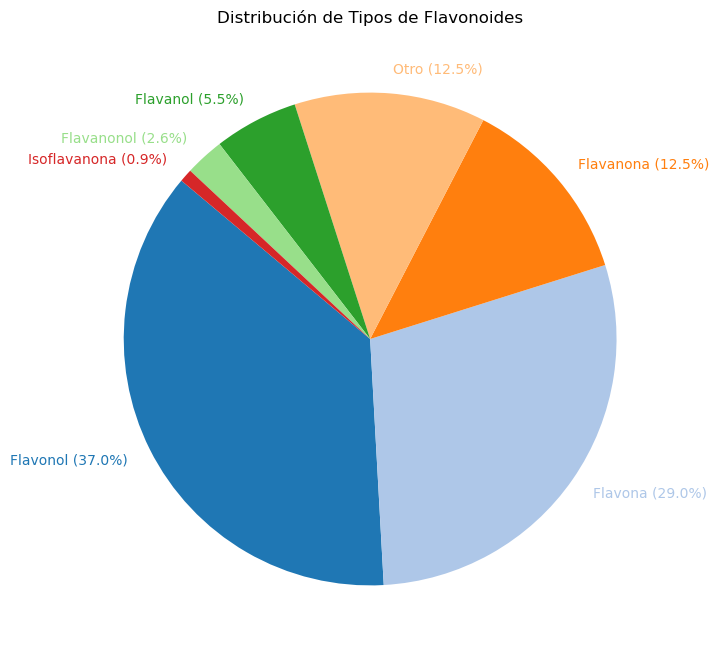

In [92]:
frequencias = df['Tipo_flavonoide'].value_counts()
porcentajes = (frequencias / frequencias.sum()) * 100
df['Tipo_flavonoide_pct'] = df['Tipo_flavonoide'].map(porcentajes) # Nueva columna
# Etiquetas
etiquetas = [f"{grupo} ({porcentaje:.1f}%)"
             for grupo, porcentaje in zip(frequencias.index, porcentajes)]
colores_segmentos = plt.cm.tab20.colors[:len(frequencias)]

# Plot
plt.figure(figsize=(8, 8))
pie_chart = plt.pie(frequencias, labels=etiquetas, autopct='', startangle=140, colors=colores_segmentos, textprops={'color': 'black'})
plt.title('Distribución de Tipos de Flavonoides')
# Colorear el texto con el color del segmento correspondiente
for texto, color in zip(pie_chart[1], colores_segmentos):
    texto.set_color(color)
plt.show()


# Comprobar Errores
__________________________________________________________________________________________________________________________________________
Para verificar si nuestros Flavonoides fueron clasificados correctamente, comprobaremos si presentan mas de una de las estructuras de interes. En teoría solo deben compartir estructuras Flavonas-Flavonoles y Flavanonas-Flavanonoles

In [95]:
import itertools
condiciones = [
    'Estructura_isoflavanona',
    'Estructura_flavona',
    'Estructura_flavonol',
    'Estructura_flavanona',
    'Estructura_flavanonol',
    'Estructura_flavanol'
]

# Generar todas las combinaciones de dos estructuras
combinaciones_dos = list(itertools.combinations(condiciones, 2))
# Contar las moléculas que cumplen con cada combinación de dos condiciones
for combinacion in combinaciones_dos:
    condicion_combinada = df[list(combinacion)].all(axis=1)
    moléculas_cumplen = condicion_combinada.sum()
    print(f"Combinación {', '.join(combinacion)}: {moléculas_cumplen}")

Combinación Estructura_isoflavanona, Estructura_flavona: 0
Combinación Estructura_isoflavanona, Estructura_flavonol: 0
Combinación Estructura_isoflavanona, Estructura_flavanona: 0
Combinación Estructura_isoflavanona, Estructura_flavanonol: 0
Combinación Estructura_isoflavanona, Estructura_flavanol: 0
Combinación Estructura_flavona, Estructura_flavonol: 563
Combinación Estructura_flavona, Estructura_flavanona: 0
Combinación Estructura_flavona, Estructura_flavanonol: 0
Combinación Estructura_flavona, Estructura_flavanol: 0
Combinación Estructura_flavonol, Estructura_flavanona: 0
Combinación Estructura_flavonol, Estructura_flavanonol: 0
Combinación Estructura_flavonol, Estructura_flavanol: 0
Combinación Estructura_flavanona, Estructura_flavanonol: 39
Combinación Estructura_flavanona, Estructura_flavanol: 0
Combinación Estructura_flavanonol, Estructura_flavanol: 0


* #### Eliminamos columnas que ya no nos son de interes para el análisis

In [97]:
df_analisis = df.drop(columns=['Estructura_isoflavona', 'Estructura_isoflavanona', 'Estructura_flavona', 'Estructura_flavonol', 'Estructura_flavanona', 'Estructura_flavanonol','Estructura_flavanol'])

### <i class="fas fa-microscope"></i> Ver moleculas clasificadas
###### (CTRL + ENTER para actualizar molecula)

In [102]:
def mostrar_molecula_por_indice(indice):
    with output:
        clear_output(wait=True)
        if 0 <= indice < len(df):
            smiles_molecula = df.loc[indice, 'SMILES']
            print("Índice seleccionado:", indice)
            print("SMILES de la molécula:")
            print(df.loc[indice])
            fig = mostrar_molecula(smiles_molecula)
            display(fig)
        else:
            print("Índice fuera de rango. Selecciona un índice válido.")
def actualizar_slider(change):
    mostrar_molecula_por_indice(change['new'])

# Slider
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(df) - 1,
    step=1,
    continuous_update=False,
    layout=widgets.Layout(width='80%')  # Establece el ancho del slider
)
# Conectar el slider a la función de actualización
slider.observe(actualizar_slider, names='value')

# Widget 
output = widgets.Output()
display(slider, output)
mostrar_molecula_por_indice(0)

IntSlider(value=0, continuous_update=False, layout=Layout(width='80%'), max=1521)

Output()

# <u>Análisis</u>
Normalizamos escala delta g :

In [133]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# Aplica el scaler a la columna 'deltag'
df_analisis['deltag_scaled'] = scaler.fit_transform(df['deltag'].values.reshape(-1, 1))
print(df[['ChEBI ID', 'deltag', 'deltag_scaled']].sample(n=10))

      ChEBI ID  deltag  deltag_scaled
1186    168665   -10.4       0.423729
893     180423    -8.7       0.711864
902     169052   -10.1       0.474576
976     196372    -7.5       0.915254
1494    168115    -9.7       0.542373
61      192895    -9.8       0.525424
869     175772    -8.1       0.813559
914     168769   -10.6       0.389831
503     191455   -10.2       0.457627
236     174885    -8.6       0.728814


## Boxplot
Afinidad vs Tipo de flavonoide 

### </i> <i class="fas fa-eye" ></i> Afinidad a UCP2 (ΔG) vs Tipo de Flavonoide


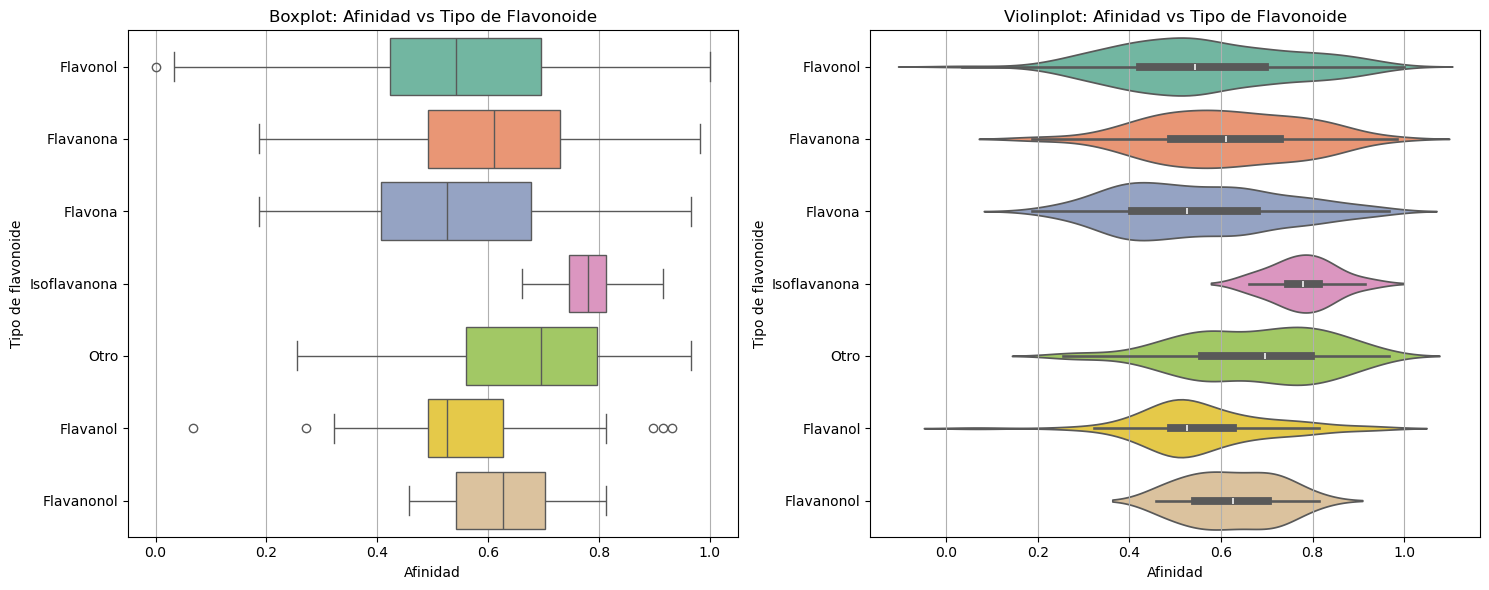

In [136]:
custom_palette = sns.color_palette("Set2", n_colors=7)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(x='deltag_scaled', y='Tipo_flavonoide', data=df_analisis, hue='Tipo_flavonoide',
            orient='h', dodge=False, palette=custom_palette, ax=axes[0])
#Boxplot
axes[0].set_xlabel('Afinidad')
axes[0].set_ylabel('Tipo de flavonoide')
axes[0].set_title('Boxplot: Afinidad vs Tipo de Flavonoide')
axes[0].grid(axis='x')  #
sns.violinplot(x='deltag_scaled', y='Tipo_flavonoide', data=df_analisis, hue='Tipo_flavonoide',
               orient='h', palette=custom_palette, ax=axes[1])
#Violinplot
axes[1].set_xlabel('Afinidad')
axes[1].set_ylabel('Tipo de flavonoide')
axes[1].set_title('Violinplot: Afinidad vs Tipo de Flavonoide')
axes[1].grid(axis='x')  
plt.tight_layout();plt.show()

## <i class="fas fa-microscope"></i> Prueba de Normalidad a Tipo de Flavonoide respecto a (Δ)G
Histograma de frecuencia

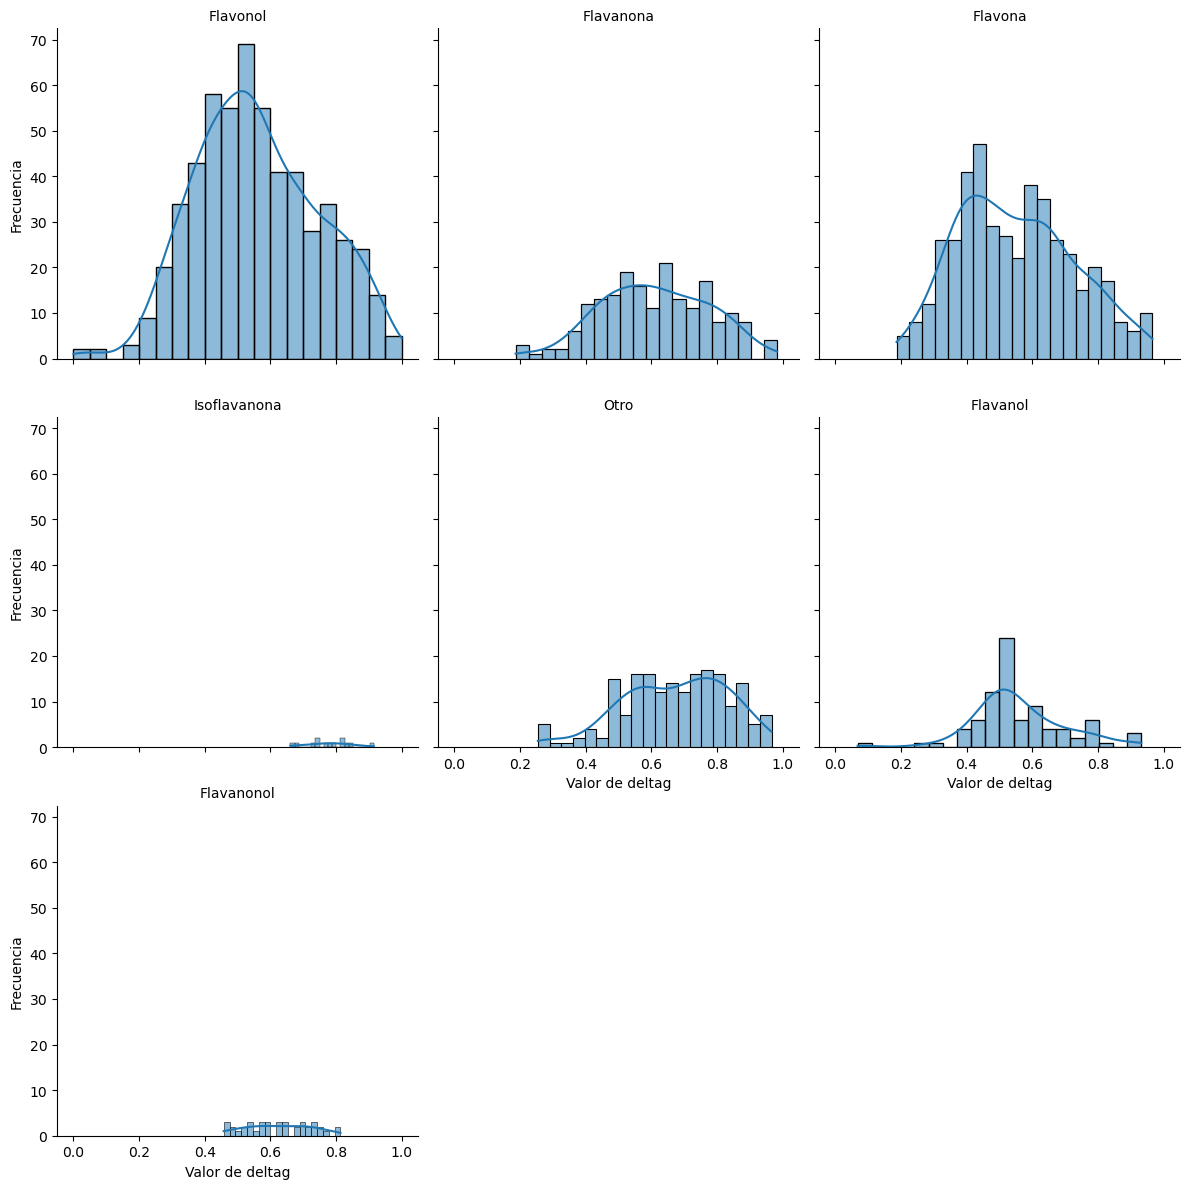

In [138]:
g = sns.FacetGrid(df_analisis, col='Tipo_flavonoide', col_wrap=3, height=4)
g.map_dataframe(sns.histplot, x='deltag_scaled', kde=True, bins=20)
g.set_axis_labels('Valor de deltag', 'Frecuencia')
g.set_titles('{col_name}')
g.set_xlabels('Valor de deltag')

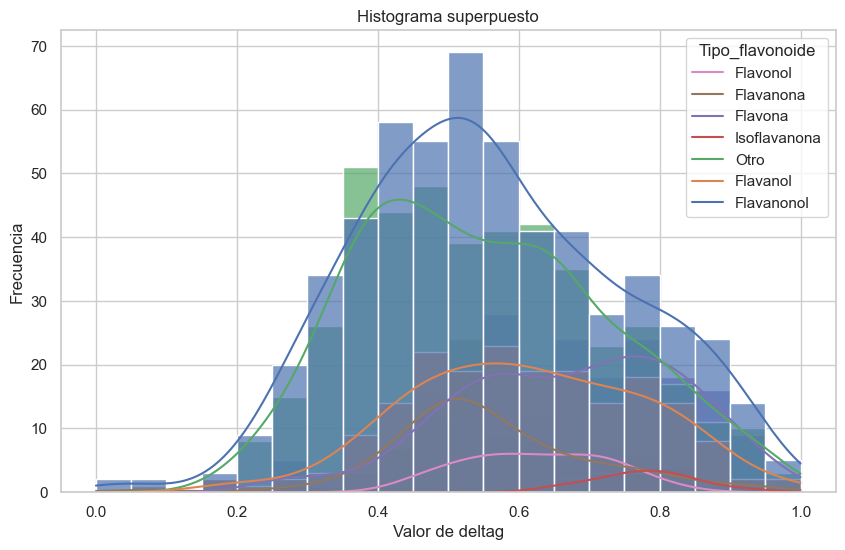

In [174]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_analisis, x='deltag_scaled', hue='Tipo_flavonoide', kde=True, bins=20, alpha=0.7)
plt.title('Histograma superpuesto')
plt.xlabel('Valor de deltag')
plt.ylabel('Frecuencia')
plt.legend(title='Tipo_flavonoide', labels=df['Tipo_flavonoide'].unique())
plt.show()

QQ Plot 

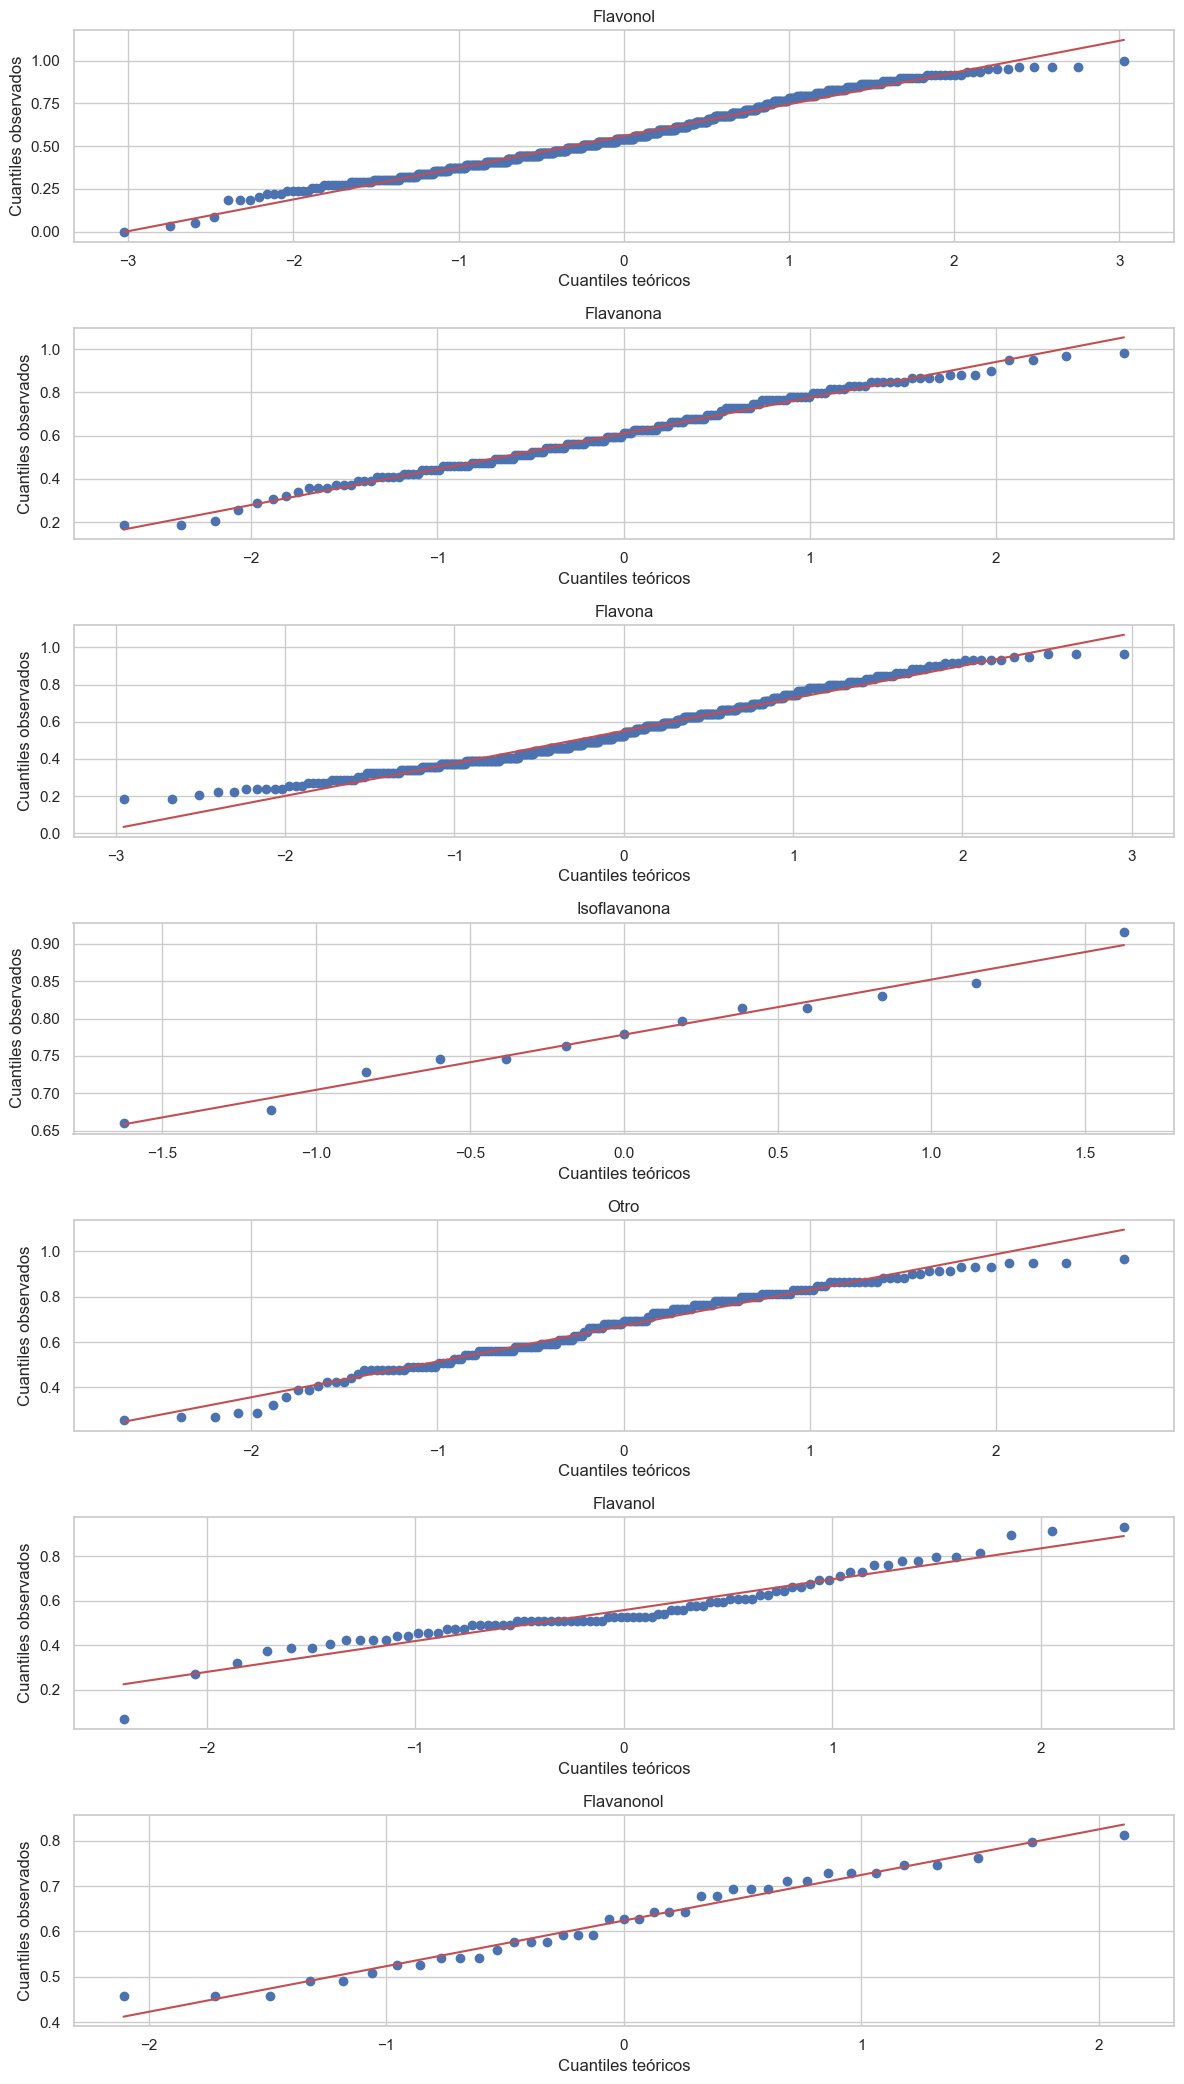

In [176]:
from scipy import stats
grupos_flavonoides = df['Tipo_flavonoide'].unique()
sns.set(style="whitegrid")
num_subplots = len(grupos_flavonoides)  # N° Subplots
plt.figure(figsize=(12, 3 * num_subplots))  
# QQplot para cada grupo
for i, grupo in enumerate(grupos_flavonoides, 1):
    datos_grupo = df_analisis[df['Tipo_flavonoide'] == grupo]['deltag_scaled']
    # Plot
    plt.subplot(num_subplots, 1, i)
    stats.probplot(datos_grupo, dist="norm", plot=plt)
    plt.title(f'{grupo}')
    plt.xlabel('Cuantiles teóricos')
    plt.ylabel('Cuantiles observados')   
plt.tight_layout();plt.show()

* #### Los grupos parecen tener una distribución <span style="font-weight: bold; font-style: italic; font-size: 35px;">Normal</span>

## <i class="fas fa-microscope"></i> Pruebas de Homocedasticidad : 

# Test de Levenne
Prueba apropiada para distribuciones no normales

In [142]:
from scipy.stats import levene
grouped_data = df_analisis.groupby('Tipo_flavonoide')['deltag_scaled']  # Groupby
data_groups = [group.values for name, group in grouped_data]   # Lista
# Test de Levenne
statistic, p_value = levene(*data_groups)
print("Estadístico de Levene:", statistic)
print("Valor p:", p_value)
# Significancia
alpha = 0.05
if p_value > alpha:
    print("No se rechaza la hipótesis nula. Las varianzas son homogéneas.")
else:
    print("Se rechaza la hipótesis nula. Las varianzas no son homogéneas.")

Estadístico de Levene: 7.515815399875181
Valor p: 5.8952786126851915e-08
Se rechaza la hipótesis nula. Las varianzas no son homogéneas.


# Test de Barlette
Prueba apropiada para distribuciones normales


In [ ]:
from scipy.stats import bartlett
grouped_data = [group['deltag_scaled'].dropna() for name, group in df_analisis.groupby('Tipo_flavonoide')]  # Groupby
bartlett_result = bartlett(*grouped_data)
print("Estadístico de Bartlett:", bartlett_result.statistic)
print("Valor p de Bartlett:", bartlett_result.pvalue)
# Significancia
if bartlett_result.pvalue > 0.05:
    print("No se rechaza la hipótesis nula. Las varianzas son homogéneas.")
else:
    print("Se rechaza la hipótesis nula. Las varianzas no son homogéneas.")

## ANOVA de Welch
El ANOVA de Welch es una técnica estadística utilizada para comparar las medias de tres o más grupos 
cuando se asume que las varianzas entre los grupos son diferentes. A diferencia del ANOVA tradicional, 
que asume homocedasticidad (igualdad de varianzas), el ANOVA de Welch es robusto frente a violaciones de esta 
suposición. Esto lo hace especialmente útil cuando se trabaja con datos que tienen varianzas heterogéneas.

La siguiente tabla muestra los resultados del ANOVA de Welch realizado para comparar la variable 
dependiente 'deltag_scaled' entre los diferentes grupos definidos por 'Tipo_flavonoide'. 

Columnas de la tabla:
- Fuente: La fuente de variación (en este caso, el tipo de Flavonoide).
- Grados de Libertad 1: Los grados de libertad asociados con la variación entre grupos.
- Grados de Libertad 2: Los grados de libertad asociados con la variación dentro de los grupos.
- Estadístico F: La estadística F calculada.
- Valor p: El valor p asociado con la estadística F. Un valor p menor que 0.05 indica que hay diferencias significativas entre las medias de los grupos.
- Tamaño del efecto: Una medida del tamaño del efecto (por ejemplo, el epsilon cuadrado).

In [144]:
import pingouin as pg
from tabulate import tabulate
# ANOVA de Welch
anova_result = pg.welch_anova(dv='deltag_scaled', between='Tipo_flavonoide', data=df_analisis)
# Renombrar las columnas 
anova_result.columns = [
    "Fuente",             # Originalmente 'Source'
    "Grados de Libertad 1",  # Originalmente 'ddof1'
    "Grados de Libertad 2",  # Originalmente 'ddof2'
    "Estadístico F",      # Originalmente 'F'
    "Valor p",            # Originalmente 'p-unc'
    "Tamaño del efecto"   # Originalmente 'np2'
]
anova_result_rounded = anova_result.round(4) # Redondear a 4 decimales 
print("Resultados del ANOVA de Welch:")
print(tabulate(anova_result_rounded, headers='keys', tablefmt='grid'))

Resultados del ANOVA de Welch:
+----+-----------------+------------------------+------------------------+-----------------+-----------+---------------------+
|    | Fuente          |   Grados de Libertad 1 |   Grados de Libertad 2 |   Estadístico F |   Valor p |   Tamaño del efecto |
+====+=================+========================+========================+=================+===========+=====================+
|  0 | Tipo_flavonoide |                      6 |                134.883 |         31.6862 |         0 |              0.0629 |
+----+-----------------+------------------------+------------------------+-----------------+-----------+---------------------+


# Prueba de Games-Howell
La prueba de Games-Howell es una prueba post hoc utilizada para realizar comparaciones múltiples entre las medias de los grupos
cuando se ha detectado heterocedasticidad (diferencias en las varianzas) y se han encontrado diferencias significativas mediante un
ANOVA de Welch. Esta prueba no asume homocedasticidad y es robusta frente a diferencias en el tamaño de las muestras.

La siguiente tabla muestra los resultados de la prueba de Games-Howell realizada para comparar las medias de la variable
dependiente 'deltag_scaled' entre los diferentes grupos definidos por 'Tipo_flavonoide'.

Columnas de la tabla:
- A: Primer grupo en la comparación.
- B: Segundo grupo en la comparación.
- mean(A): Media de la variable dependiente para el primer grupo.
- mean(B): Media de la variable dependiente para el segundo grupo.
- diff: Diferencia de medias entre los grupos.
- se: Error estándar de la diferencia de medias.
- T: Estadístico t calculado para la diferencia de medias.
- p-tukey: Valor p ajustado de Tukey para la diferencia de medias. Un valor p menor que 0.05 indica que hay una diferencia significativa entre los dos grupos.
- hedges: Tamaño del efecto Hedges' g.

In [146]:
# Realizar la prueba post hoc de Games-Howell
posthoc = pg.pairwise_gameshowell(dv='deltag_scaled', between='Tipo_flavonoide', data=df_analisis)
print("Resultados de la prueba post hoc de Games-Howell:")
print(tabulate(posthoc, headers='keys', tablefmt='grid'))

Resultados de la prueba post hoc de Games-Howell:
+----+--------------+--------------+-----------+-----------+-------------+-----------+-------------+----------+-------------+-------------+
|    | A            | B            |   mean(A) |   mean(B) |        diff |        se |           T |       df |        pval |      hedges |
+====+==============+==============+===========+===========+=============+===========+=============+==========+=============+=============+
|  0 | Flavanol     | Flavanona    |  0.558515 |  0.610169 | -0.0516546  | 0.0194548 |  -2.65511   | 183.169  | 0.115995    | -0.326703   |
+----+--------------+--------------+-----------+-----------+-------------+-----------+-------------+----------+-------------+-------------+
|  1 | Flavanol     | Flavanonol   |  0.558515 |  0.624076 | -0.0655616  | 0.0220594 |  -2.97205   | 102.224  | 0.0550104   | -0.503983   |
+----+--------------+--------------+-----------+-----------+-------------+-----------+-------------+----------

### </i> <i class="fas fa-eye" ></i> Boxplots

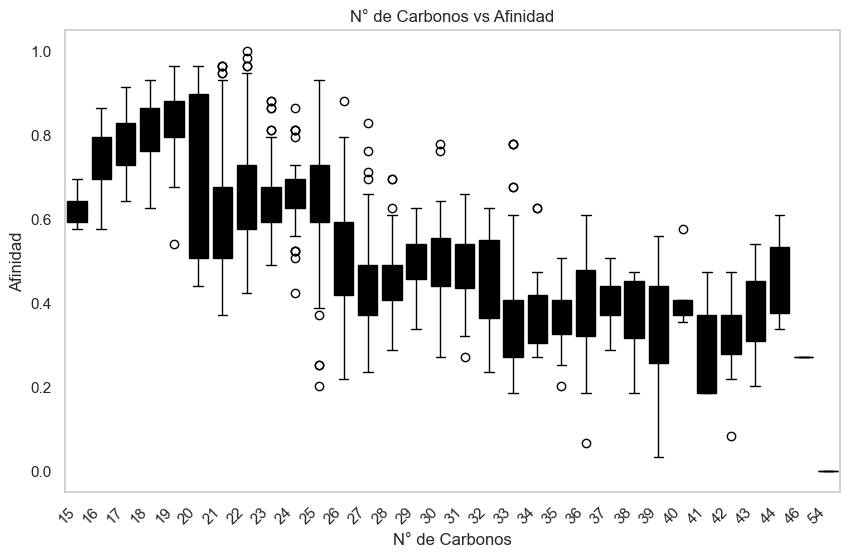

In [148]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='N°Carbonos', y='deltag_scaled', data=df_analisis, color='black')
# Plot
plt.xlabel('N° de Carbonos')
plt.ylabel('Afinidad')
plt.title('N° de Carbonos vs Afinidad')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

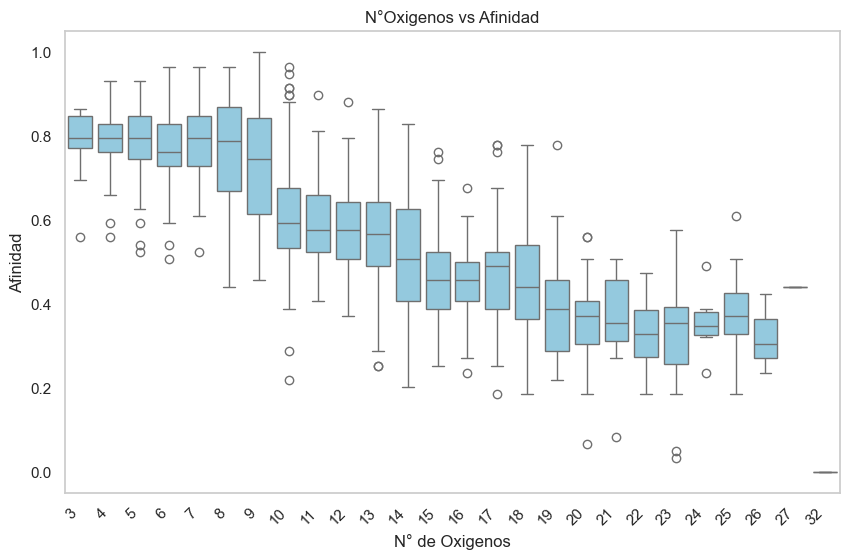

In [150]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='N°Oxigenos', y='deltag_scaled', data=df_analisis, color='skyblue')
# Plot
plt.xlabel('N° de Oxigenos')
plt.ylabel('Afinidad')
plt.title('N°Oxigenos vs Afinidad')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

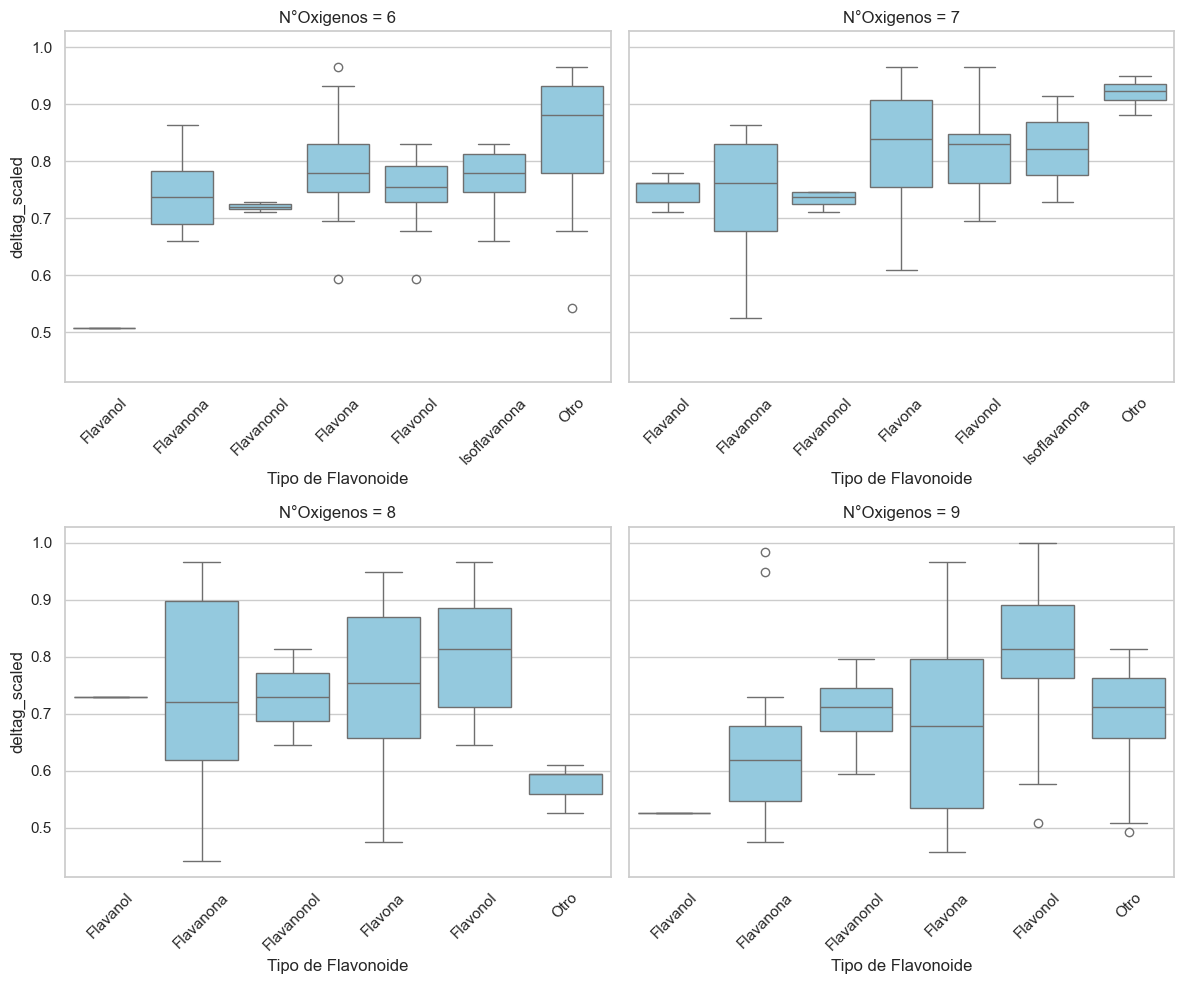

In [158]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
# Lista de valores de 'N°Oxigenos' a analizar
valores_n_oxigenos = [6, 7, 8, 9]
for i, n_oxigenos in enumerate(valores_n_oxigenos):
    filtro_n_oxigenos = df_analisis[df['N°Oxigenos'] == n_oxigenos].sort_values(by='Tipo_flavonoide')
    sns.boxplot(x='Tipo_flavonoide', y='deltag_scaled', data=filtro_n_oxigenos, color="skyblue", ax=axes[i//2, i%2])
    axes[i//2, i%2].set_xlabel('Tipo de Flavonoide')
    axes[i//2, i%2].set_ylabel('deltag_scaled')
    axes[i//2, i%2].set_title(f'N°Oxigenos = {n_oxigenos}')
    axes[i//2, i%2].tick_params(axis='x', rotation=45)
plt.tight_layout();plt.show()

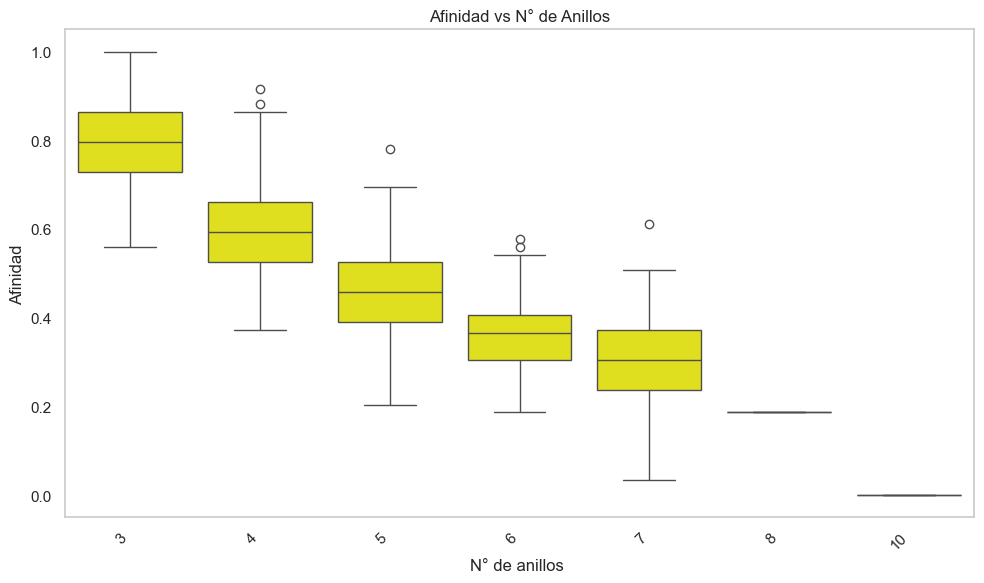

In [160]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='N°Anillos', y='deltag_scaled', data=df_analisis, color='yellow')
# Plot
plt.xlabel('N° de anillos ')
plt.ylabel('Afinidad')
plt.title('Afinidad vs N° de Anillos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()

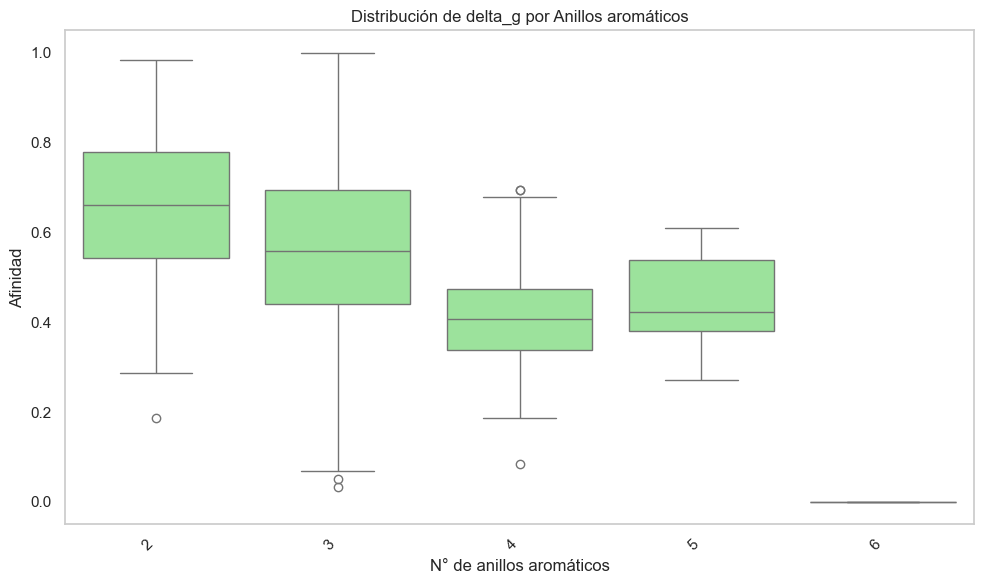

In [162]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='N°Aromaticos', y='deltag_scaled', data=df_analisis, color="lightgreen")
# Plot
plt.xlabel('N° de anillos aromáticos')
plt.ylabel('Afinidad')
plt.title('Distribución de delta_g por Anillos aromáticos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()

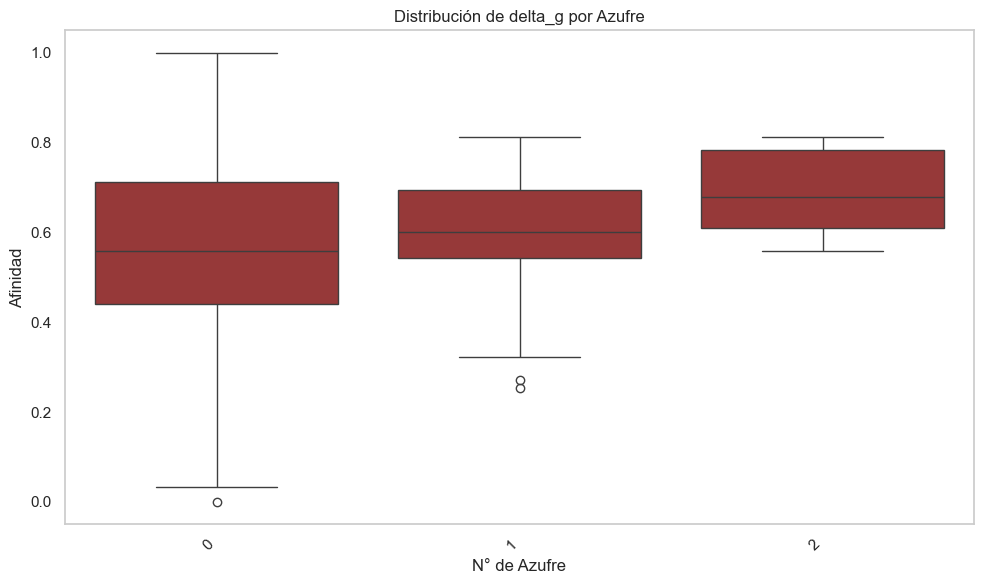

In [164]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='N°S', y='deltag_scaled', data=df_analisis, color="brown")
# Plot
plt.xlabel('N° de Azufre')
plt.ylabel('Afinidad')
plt.title('Distribución de delta_g por Azufre')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()